# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- <b>Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.</b><br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

`utils.py` is a file where there are some methods used in this and the other notebooks generated for the project.

In [1]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
players_df = pd.DataFrame(players)

events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}

### Some data preparation

With the function `prepare_players`, only the columns `playerId` and `role` of the `players_df` DataFrame are kept, in order to use this information to make further analysis, based on the role of each player. Look at the `utils.py` file for further information.

In [4]:
players_df = prepare_players(players_df)

All the events with _Goal Kick_ and _Save attempt_ are removed from all the DataFrames, since they all have a dummy value as a starting position, which can be either {'y': 0, 'x': 0} or {'y': 100, 'x': 100} and they would influence and modify the real distance traveled by goalkeepers. (Reference: https://dataglossary.wyscout.com/goal_kick/).

In [5]:
events_to_check = pd.DataFrame()
for nation in events_df:
    goal_kick_events = events_df[nation][(events_df[nation]['subEventName'] == 'Goal kick')]
    save_attempt_events = events_df[nation][(events_df[nation]['eventName'] == 'Save attempt')]
    events_to_check = pd.concat([events_to_check, goal_kick_events, save_attempt_events])

In [6]:
for row in events_to_check.iterrows():
    if not (row[1]['positions'][0] == {'y': 0, 'x': 0} or row[1]['positions'][0] == {'y': 100, 'x': 100}):
        print(True)

As expected, all the events with _Goal kick_ as `subEventName` and all the events with _Save attempt_ as `eventName` have as starting position dummy values, so for the analysis purpose they are noise and for this reason removed from all the DataFrames.

In [7]:
for nation in events_df:
    events_df[nation] = events_df[nation][(events_df[nation]['subEventName'] != 'Goal kick')]
    events_df[nation] = events_df[nation][(events_df[nation]['eventName'] != 'Save attempt')]

In order to analyze and get hint and interesting information about each competition, they all are first analyzed separately. In the end of the notebook is present the total distance distribution.

These variables will be used for the total analysis:

In [8]:
total_tmp_df = pd.DataFrame()
total_player_role_df = pd.DataFrame()
lineup_players_df = pd.DataFrame()
substitution_players_df = pd.DataFrame()

In [9]:
def general_analysis(competition_area, competition_name):
    print('General analysis for %s' %competition_name)
    competition_events_df = prepare_events(extract_events(events_df, competition_area))
    events_players_df = pd.merge(competition_events_df, players_df, on='playerId', how='left')

    events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_df = compute_distance(events_players_df)
    competition_tmp_df = sum_distances(events_players_distances_df)
    distances_count = count_distances(competition_tmp_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of the distances computed with the %s events' %competition_name)

    competition_players_role_distances_df = pd.merge(competition_tmp_df, players_df, on='playerId', how='left')
    players_role_distances_df = group_by_distance_role(competition_players_role_distances_df)

    plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the %s events' %competition_name)

    return competition_events_df, competition_tmp_df, competition_players_role_distances_df

In [10]:
def lineup_analysis(events_df, competition_area, competition_name):
    print('Lineup analysis for %s' %competition_name)
    
    # loading the matches data
    with open('./data/matches/matches_%s.json' %competition_area) as json_data:
        competition_matches = pd.DataFrame(json.load(json_data))

    substitutions = {}
    for match in competition_matches.iterrows():
        for key in list(match[1]['teamsData']):
            for sub in match[1]['teamsData'][key]['formation']['substitutions']:
                if(type(sub) == dict):
                    if match[1]['wyId'] in substitutions:
                        substitutions[match[1]['wyId']].append(sub['playerIn'])
                    else:
                        substitutions[match[1]['wyId']] = [sub['playerIn']]

    # removes all the events generated by the players that have been substituted
    filtered_df = pd.DataFrame()

    for match, player_ids in substitutions.items():
        filtered_df = pd.concat([filtered_df, events_df[(events_df['matchId'] == match) & (events_df['playerId'].isin(player_ids))]])

    events_no_subs_df = events_df.drop(list(filtered_df.index))
    events_no_subs_df = pd.merge(events_no_subs_df, players_df, on='playerId', how='left')

    events_no_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_no_sub_df = compute_distance(events_no_subs_df)
    
    competition_tmp_no_sub_df = sum_distances(events_players_distances_no_sub_df)

    distances_count_no_sub = count_distances(competition_tmp_no_sub_df)

    plot_histogram(distances_count_no_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only lineup players) computed with the %s events' %competition_name)

    competition_players_role_distances_no_sub_df = pd.merge(competition_tmp_no_sub_df, players_df, on='playerId', how='left')

    players_role_distances_no_sub_df = group_by_distance_role(competition_players_role_distances_no_sub_df)

    plot_histogram_per_role(players_role_distances_no_sub_df, 'Histogram of count of distances by role (with only lineup players) computed with the %s events' %competition_name)

    return filtered_df, competition_players_role_distances_no_sub_df


In [11]:
def substitution_analysis(events_df, competition_area, competition_name):
    #filtered_df is the DataFrame containing only the events generated by the players that have been substituted
    events_subs_df = pd.merge(events_df, players_df, on='playerId', how='left')

    events_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_sub_df = compute_distance(events_subs_df)
    tmp_sub_df = sum_distances(events_players_distances_sub_df)
    distances_count_sub = count_distances(tmp_sub_df)

    plot_histogram(distances_count_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only substituted players) computed with the %s events' %competition_name)

    players_role_distances_sub_df = pd.merge(tmp_sub_df, players_df, on='playerId', how='left')
    players_role_distances_sub_df = group_by_distance_role(players_role_distances_sub_df)

    plot_histogram_per_role(players_role_distances_sub_df, 'Histogram of count of distances by role (with only substituted players) computed with the %s events' %competition_name)

    return players_role_distances_sub_df

In [12]:
def total_analysis():
    print('General analysis')
    
    players_role_distances_df = group_by_distance_role(total_player_role_df)
    
    distances_count = count_distances(total_tmp_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with tall the competitions' events")
    

In [13]:
def lineup_total_analysis():
    print('Lineup analysis')

    players_role_distances_df = group_by_distance_role(lineup_players_df)
    
    distances_count = count_distances(lineup_players_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only lineup players)")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with all the competitions' events (with only lineup players)")

In [14]:
def substitution_total_analysis():
    print('Substitution analysis')

    distance_counts = substitution_players_df.groupby('distance')['count'].sum().reset_index()

    distance_counts['distance'] = distance_counts['distance'].astype(int)
    
    plot_histogram(distance_counts, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only substituted players)")

    distance_role = substitution_players_df.sort_values(by=['distance']).groupby(by=['distance', 'role'])['count'].sum().reset_index()
    plot_histogram_per_role(distance_role, "Histogram of count of distances by role computed with all the competitions' events (with only substituted players)")

## Italian first division

General analysis for Italian first division


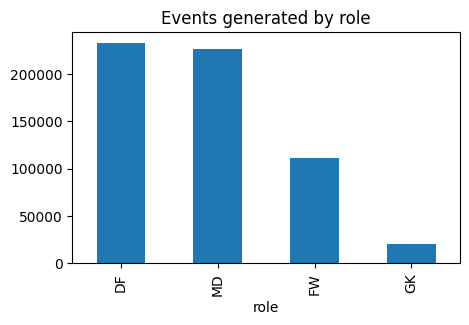

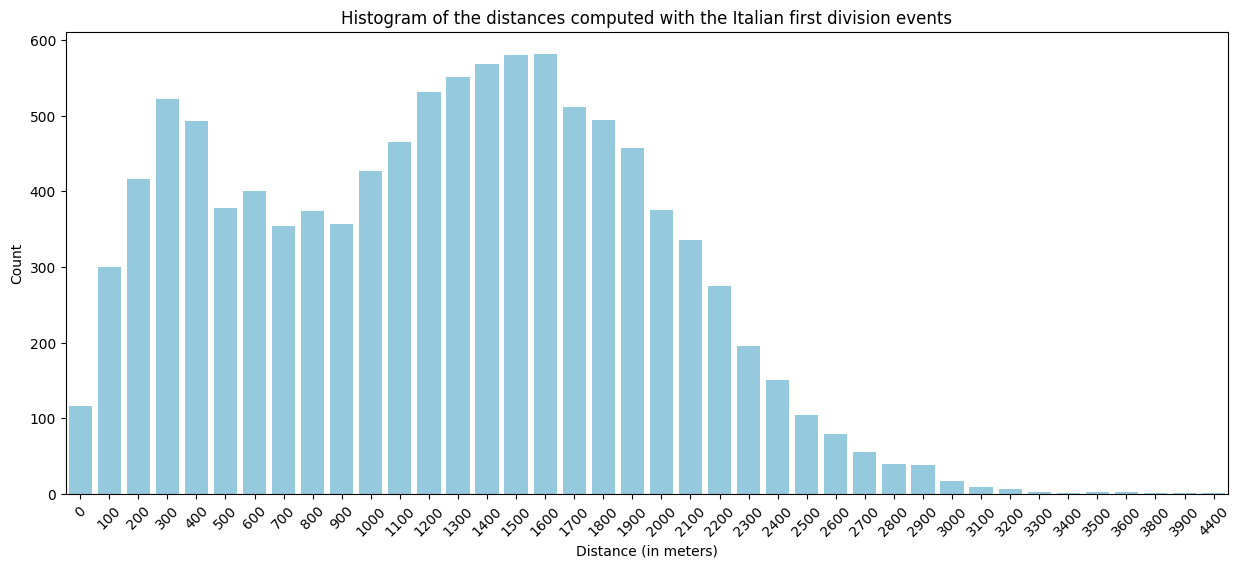

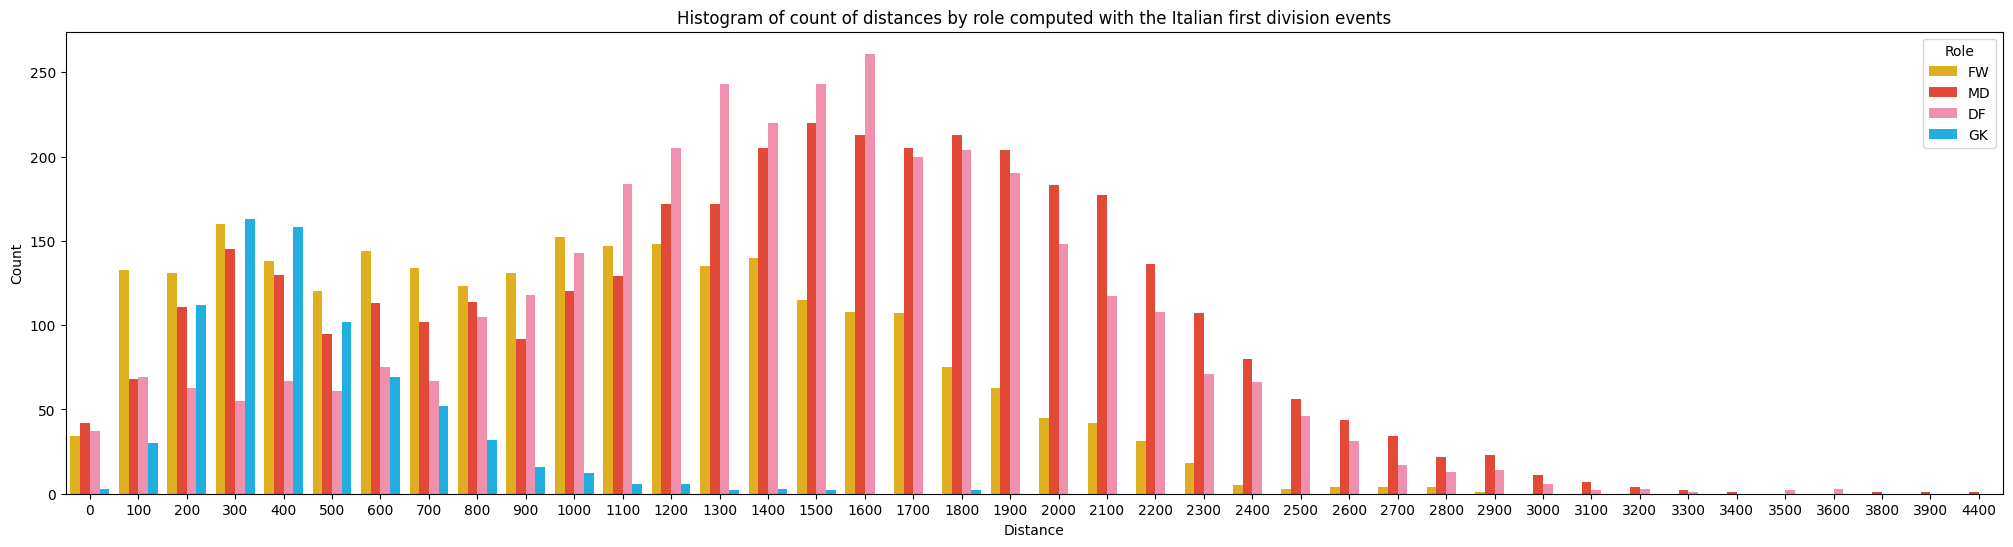

In [15]:
italian_events_df, df1, df2 = general_analysis('Italy', 'Italian first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Italian first division


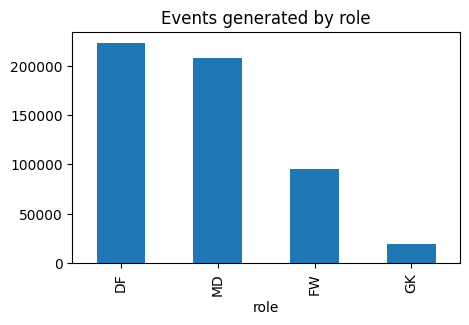

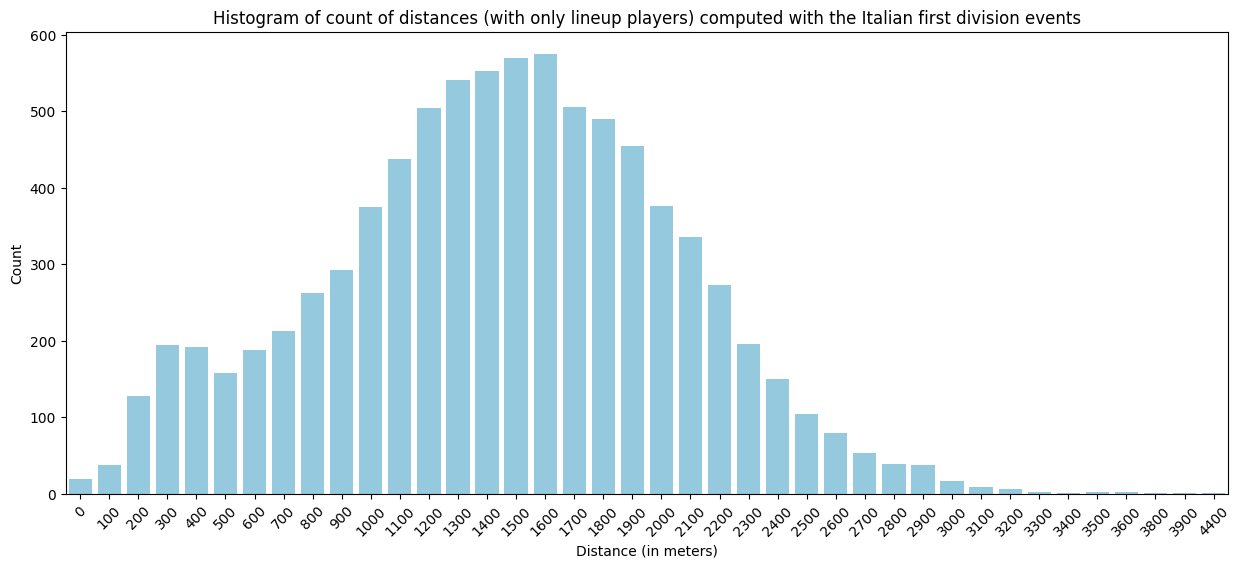

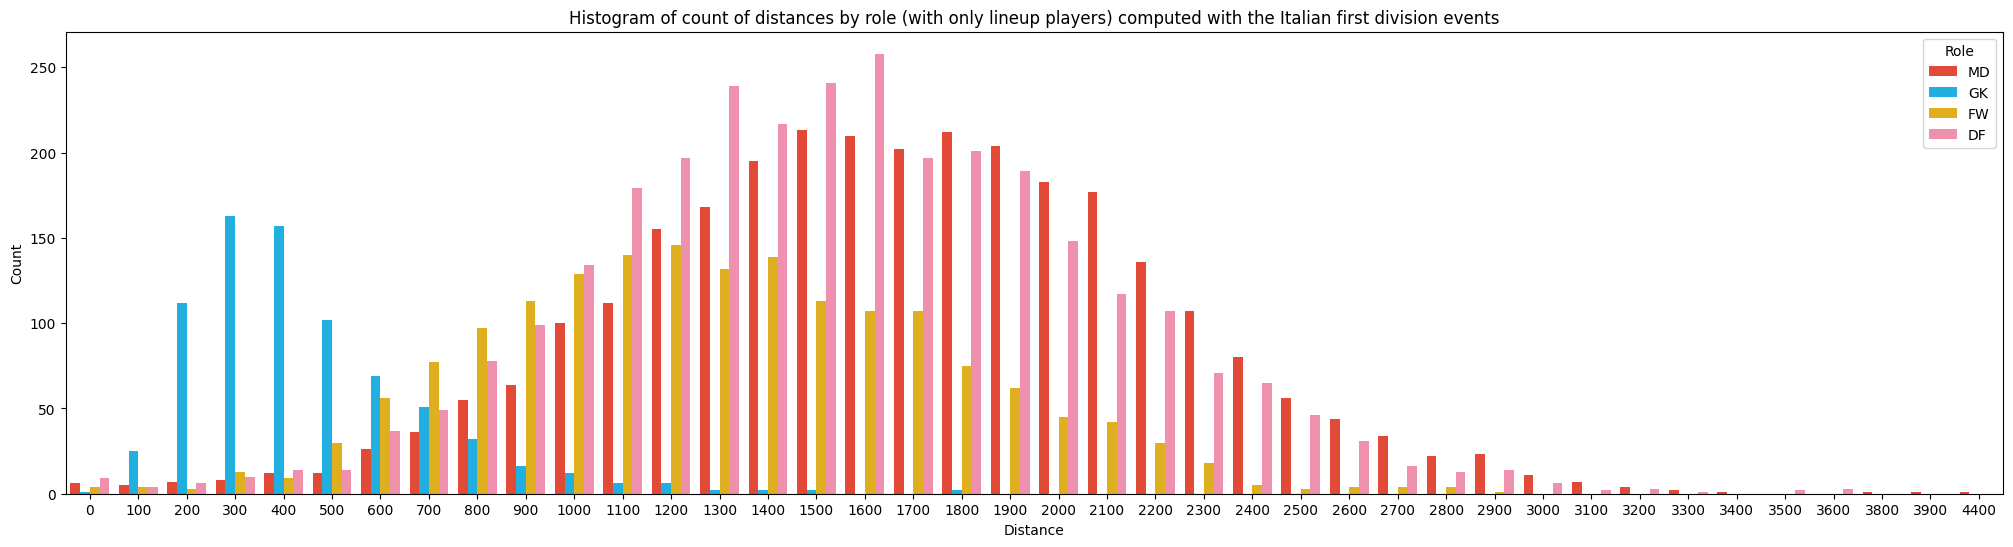

In [16]:
filtered_df, df1 = lineup_analysis(italian_events_df, 'Italy', 'Italian first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

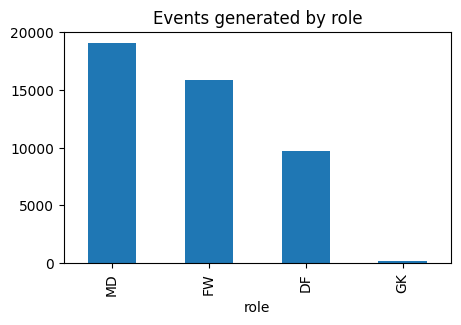

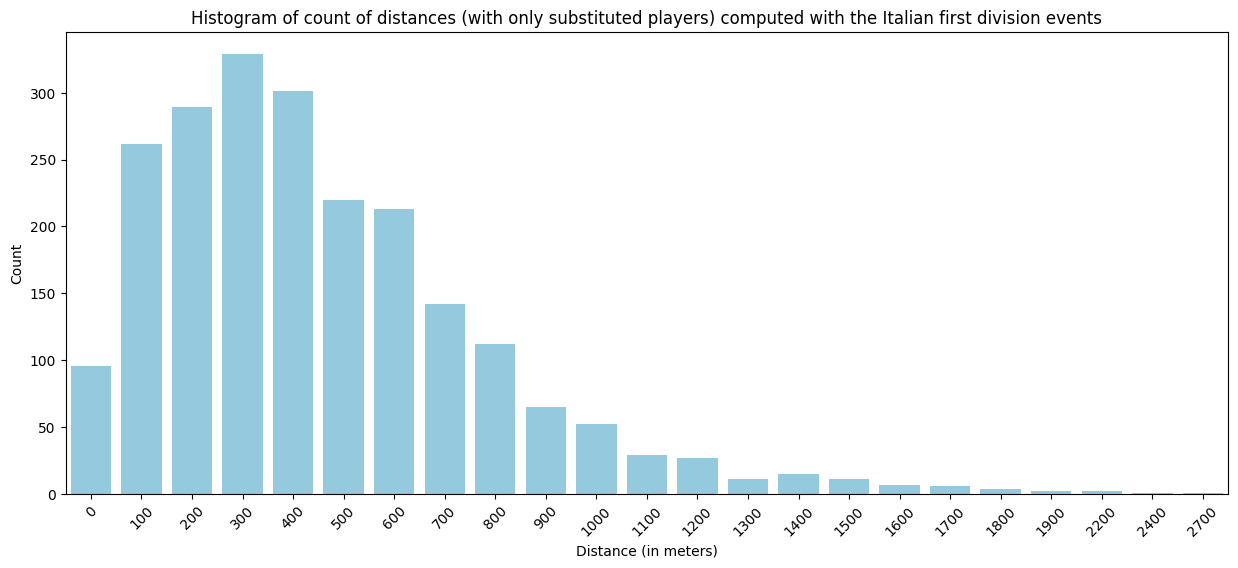

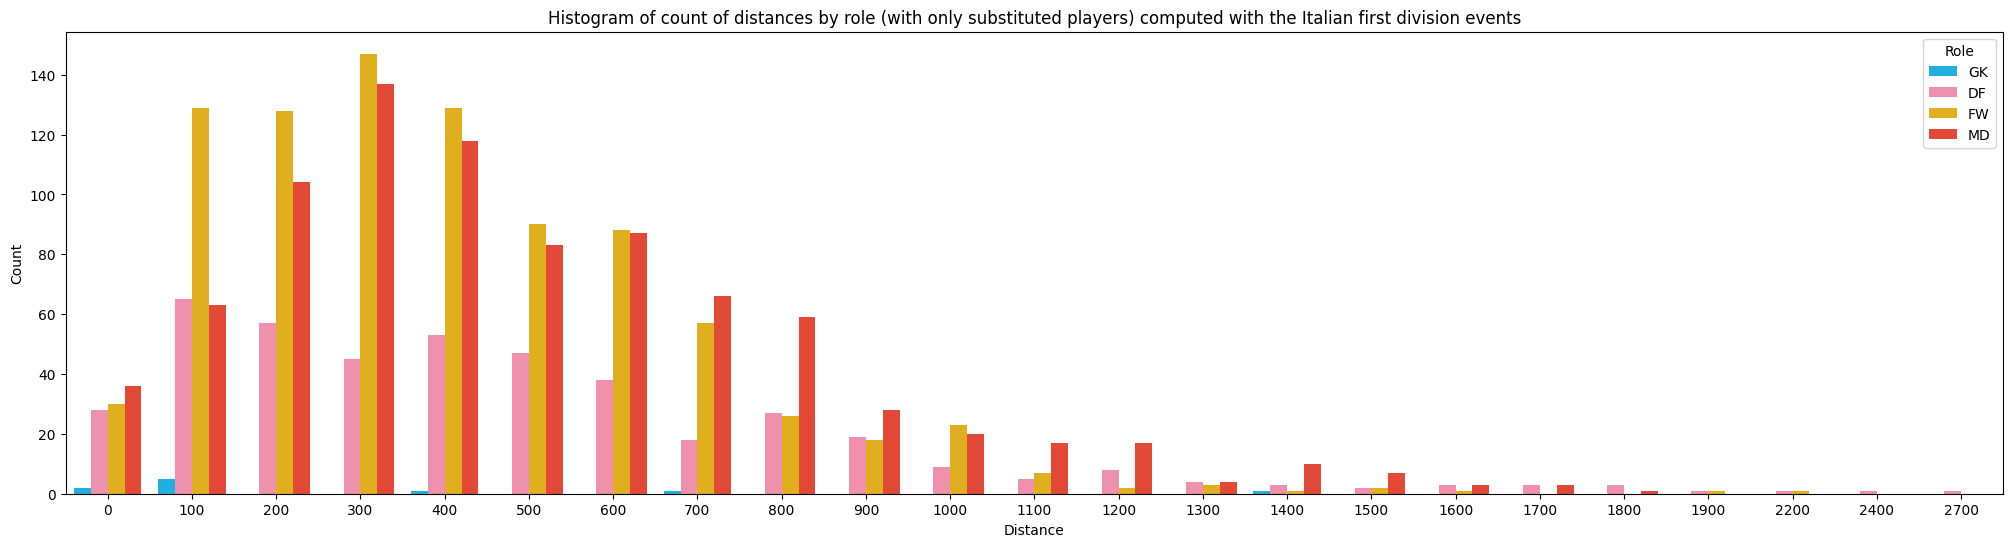

In [17]:
df1 = substitution_analysis(filtered_df, 'Italy', 'Italian first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## English first division analysis

General analysis for English first division


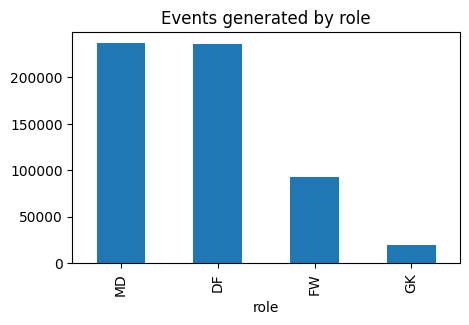

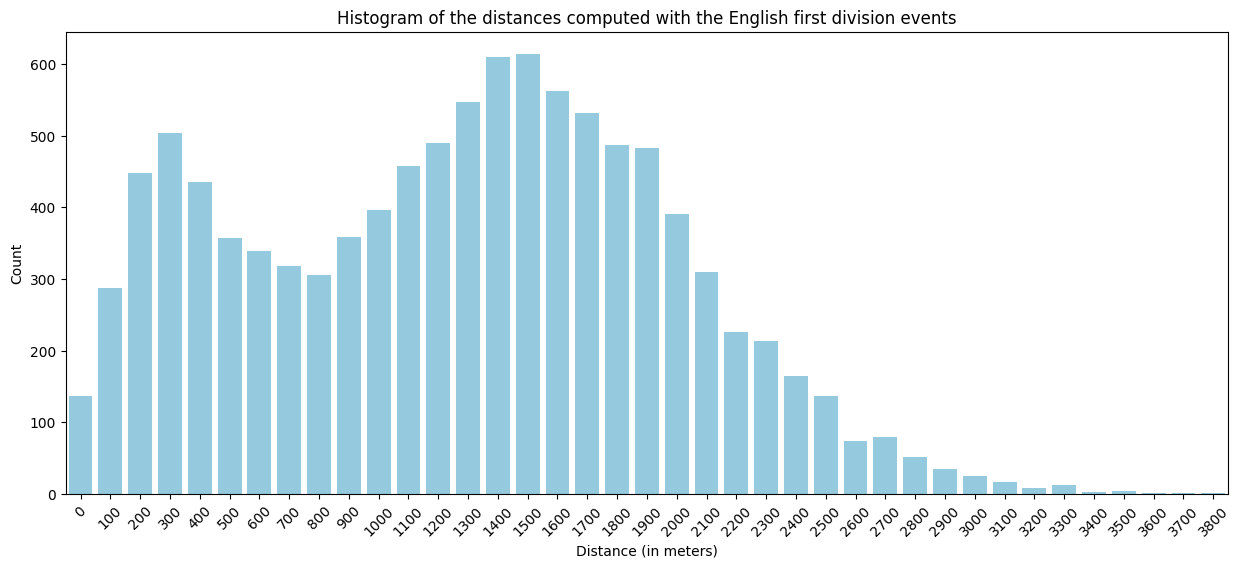

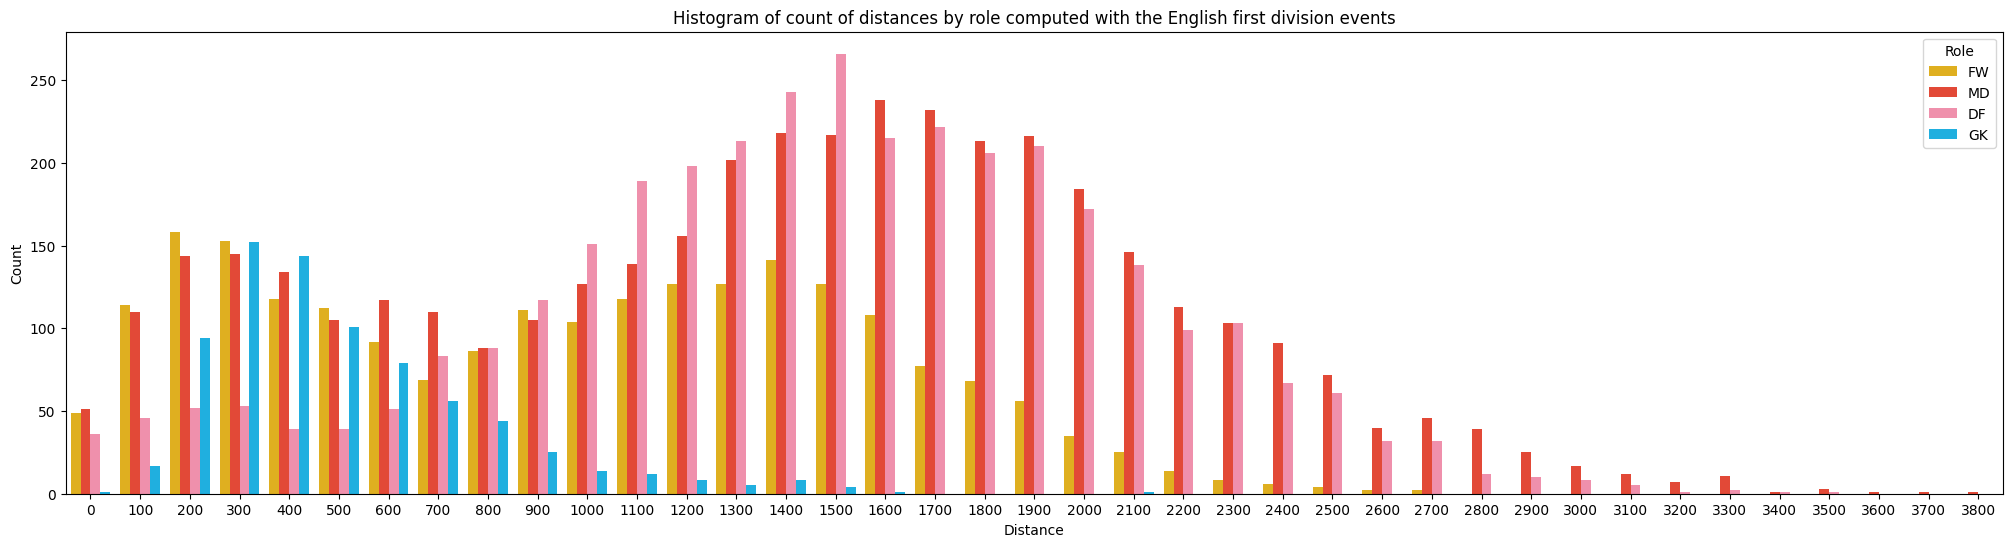

In [18]:
english_events_df, df1, df2 = general_analysis('England', 'English first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for English first division


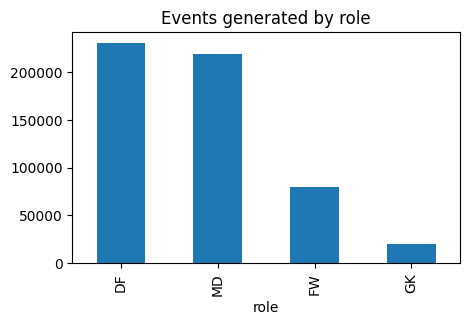

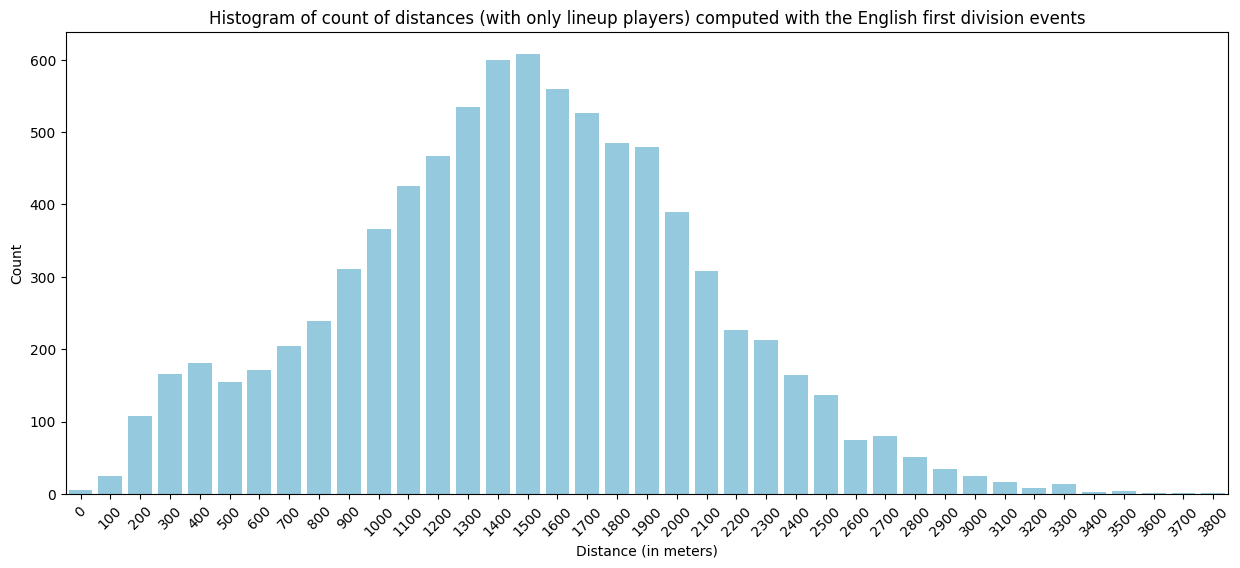

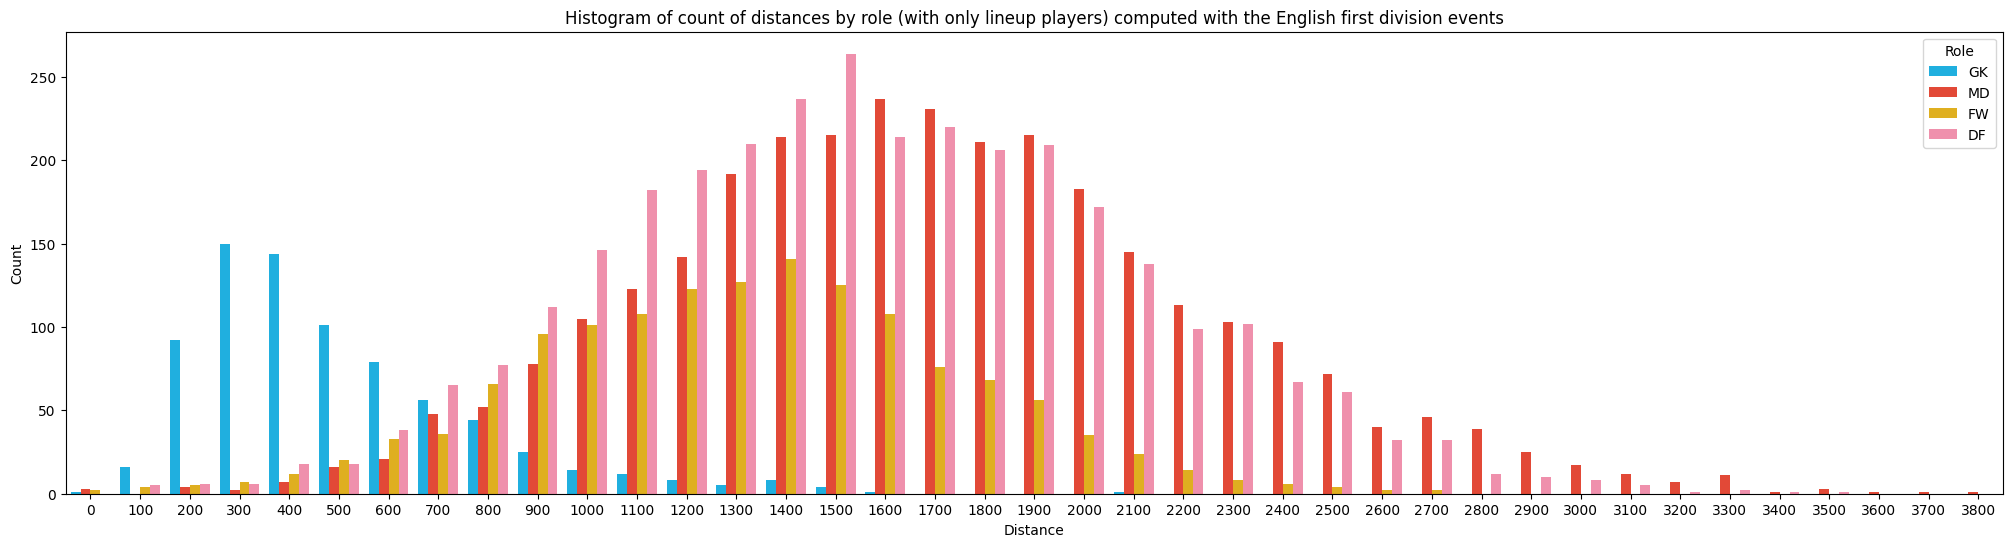

In [19]:
filtered_df, df1 = lineup_analysis(english_events_df, 'England', 'English first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

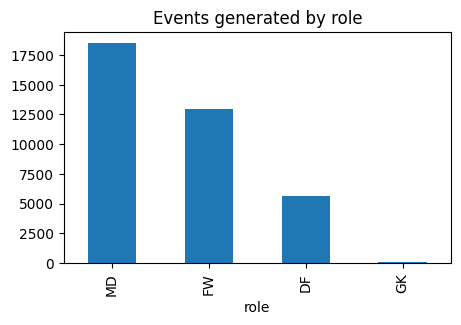

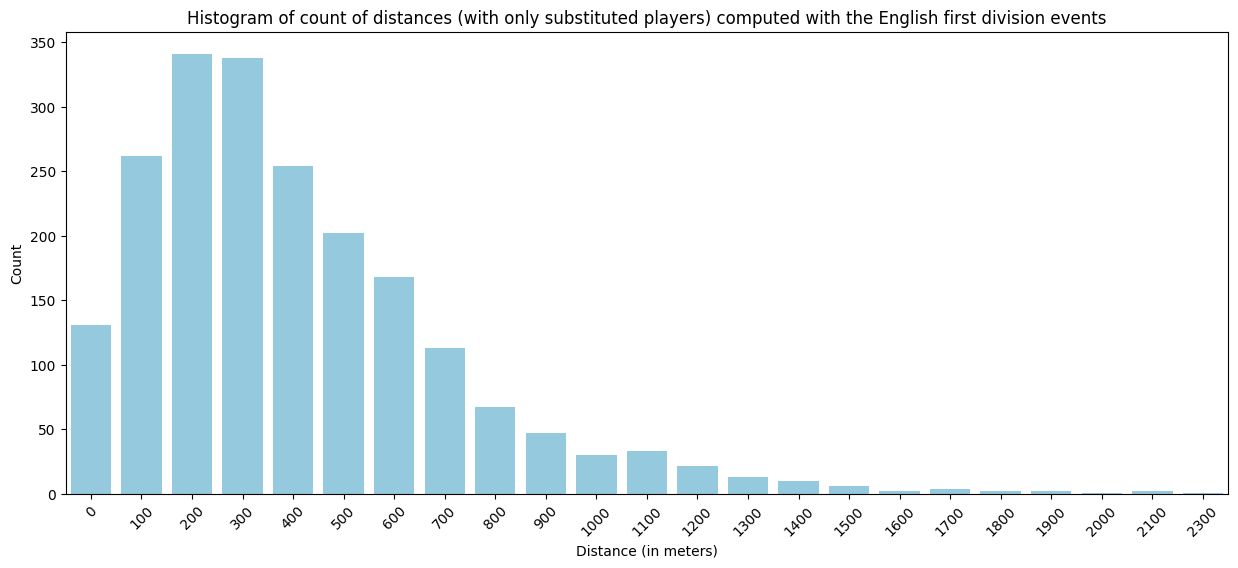

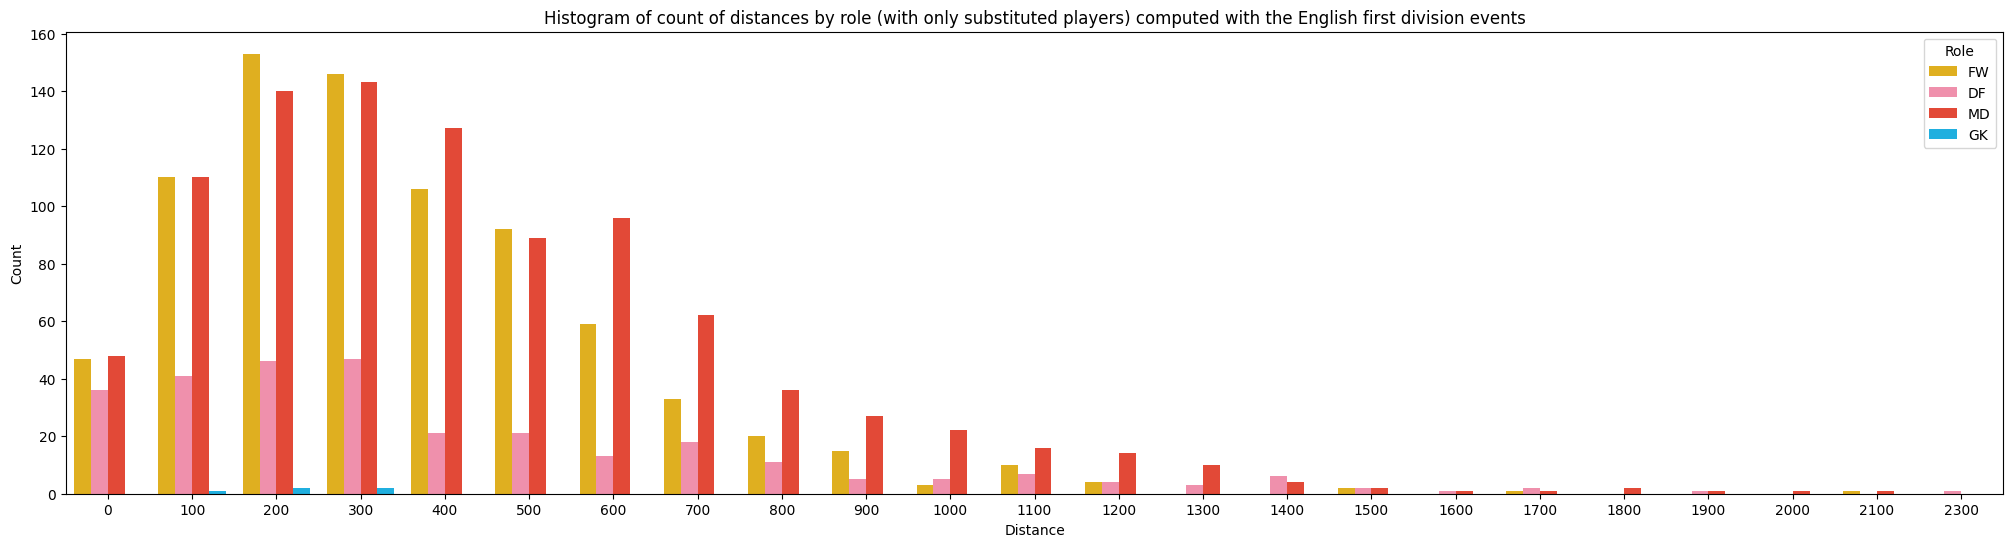

In [20]:
df1 = substitution_analysis(filtered_df, 'England', 'English first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Spanish first division analysis

General analysis for Spanish first division


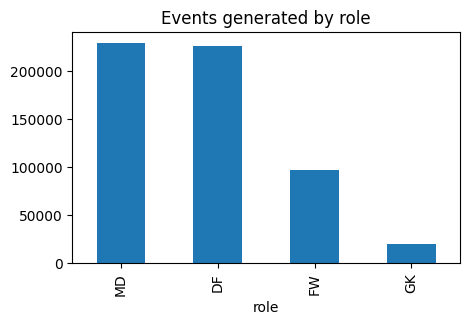

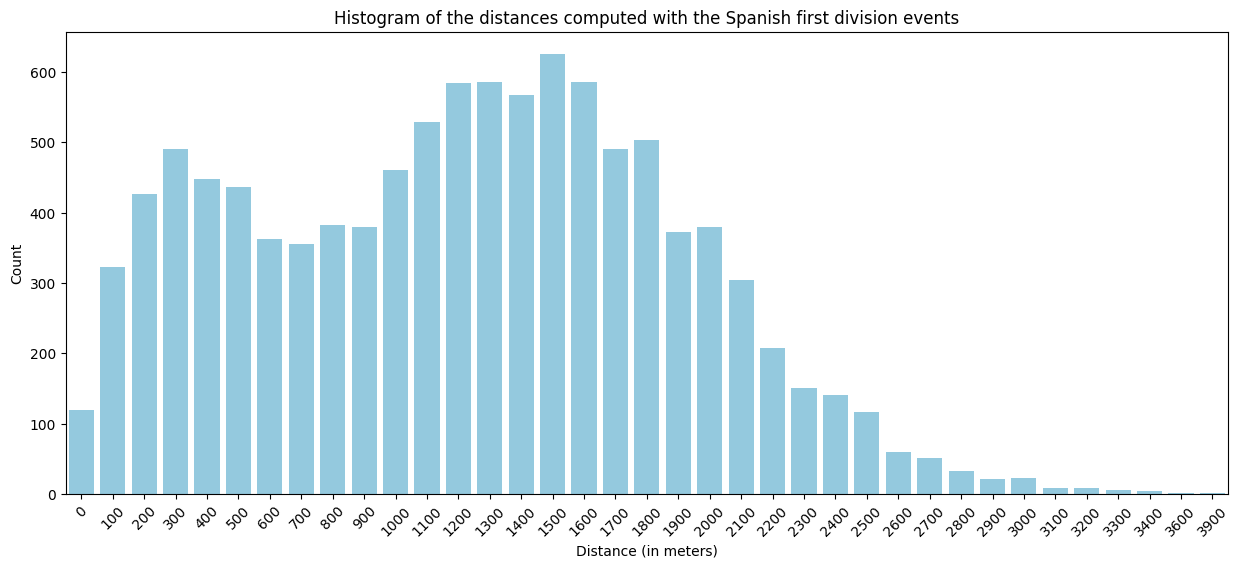

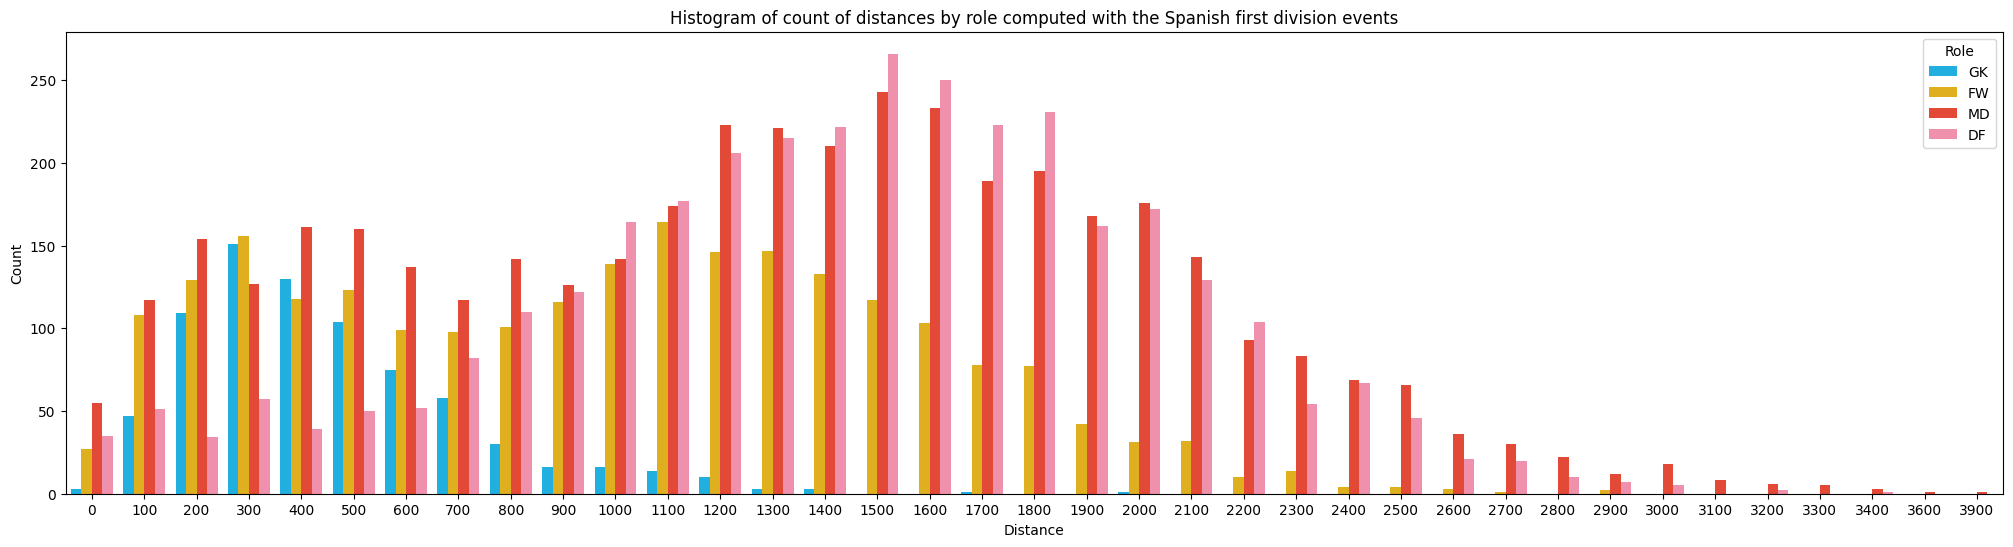

In [21]:
spanish_events_df, df1, df2 = general_analysis('Spain', 'Spanish first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Spanish first division


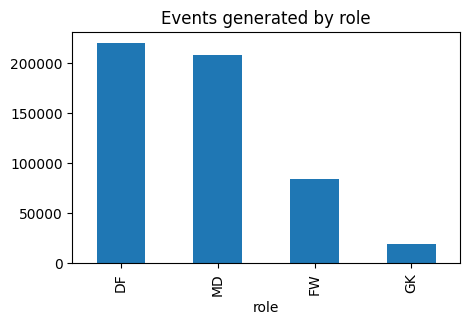

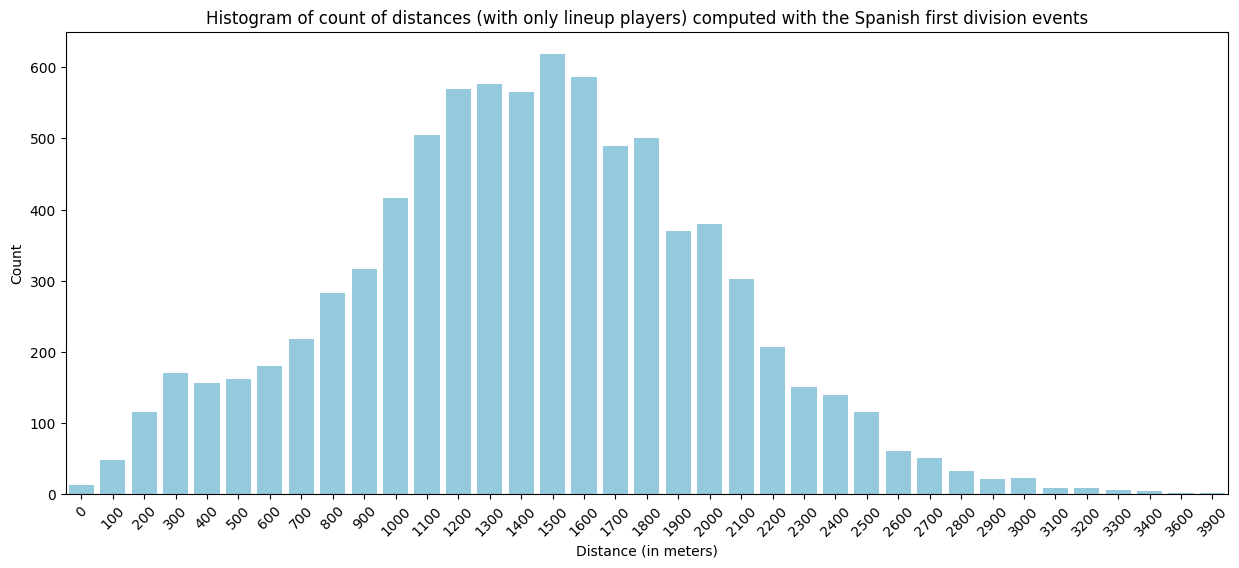

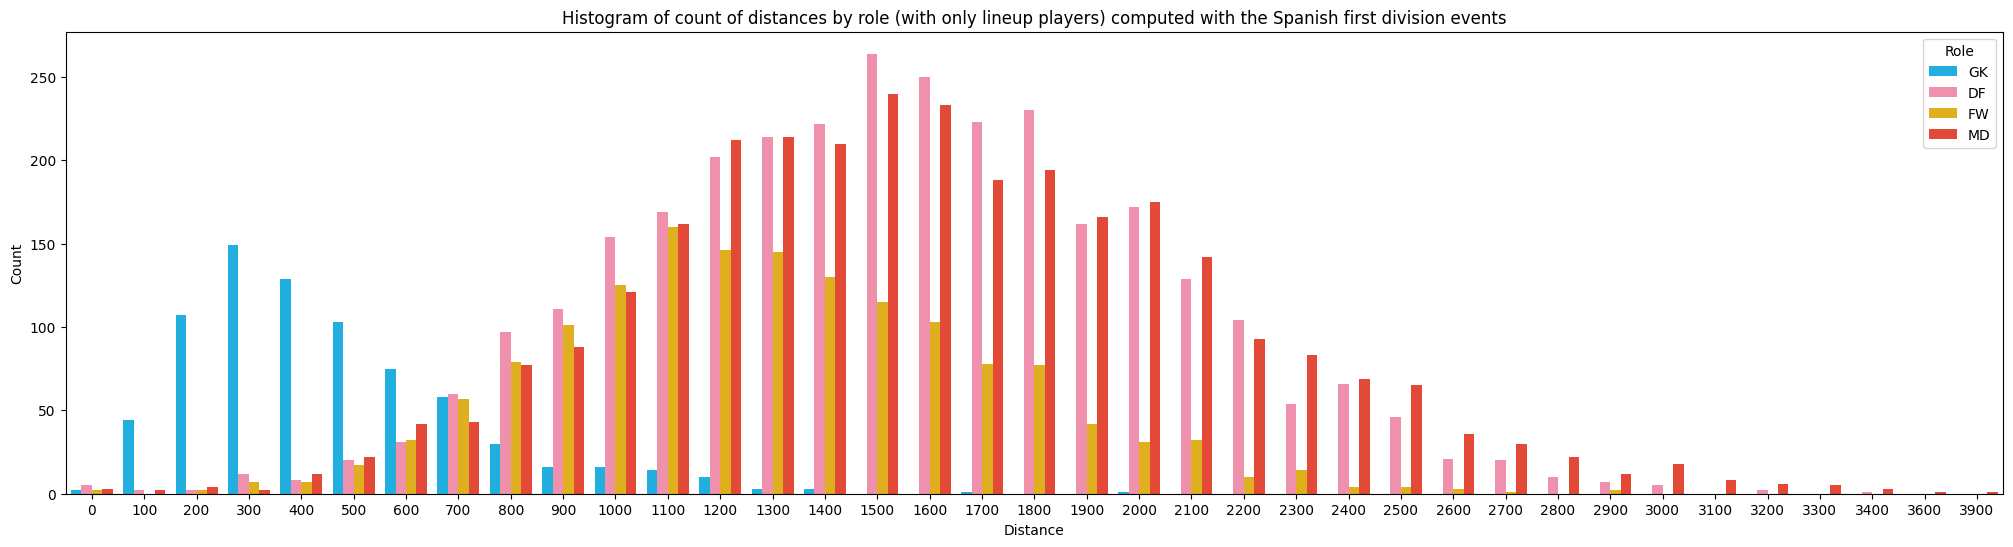

In [22]:
filtered_df, df1 = lineup_analysis(spanish_events_df, 'Spain', 'Spanish first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

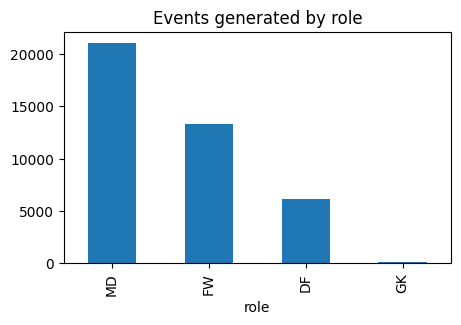

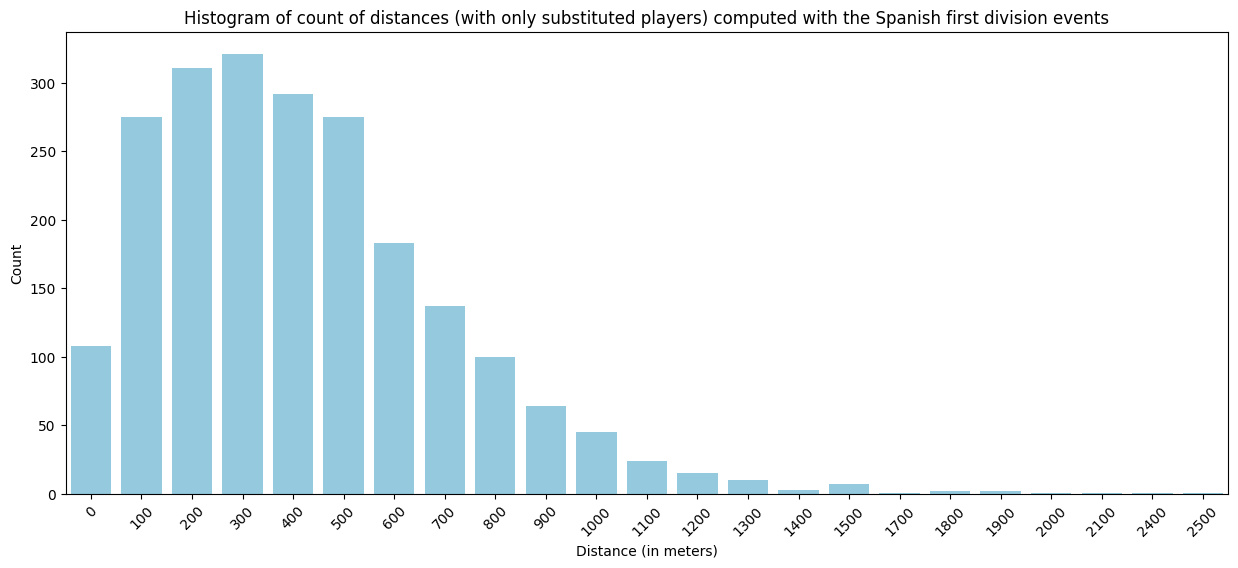

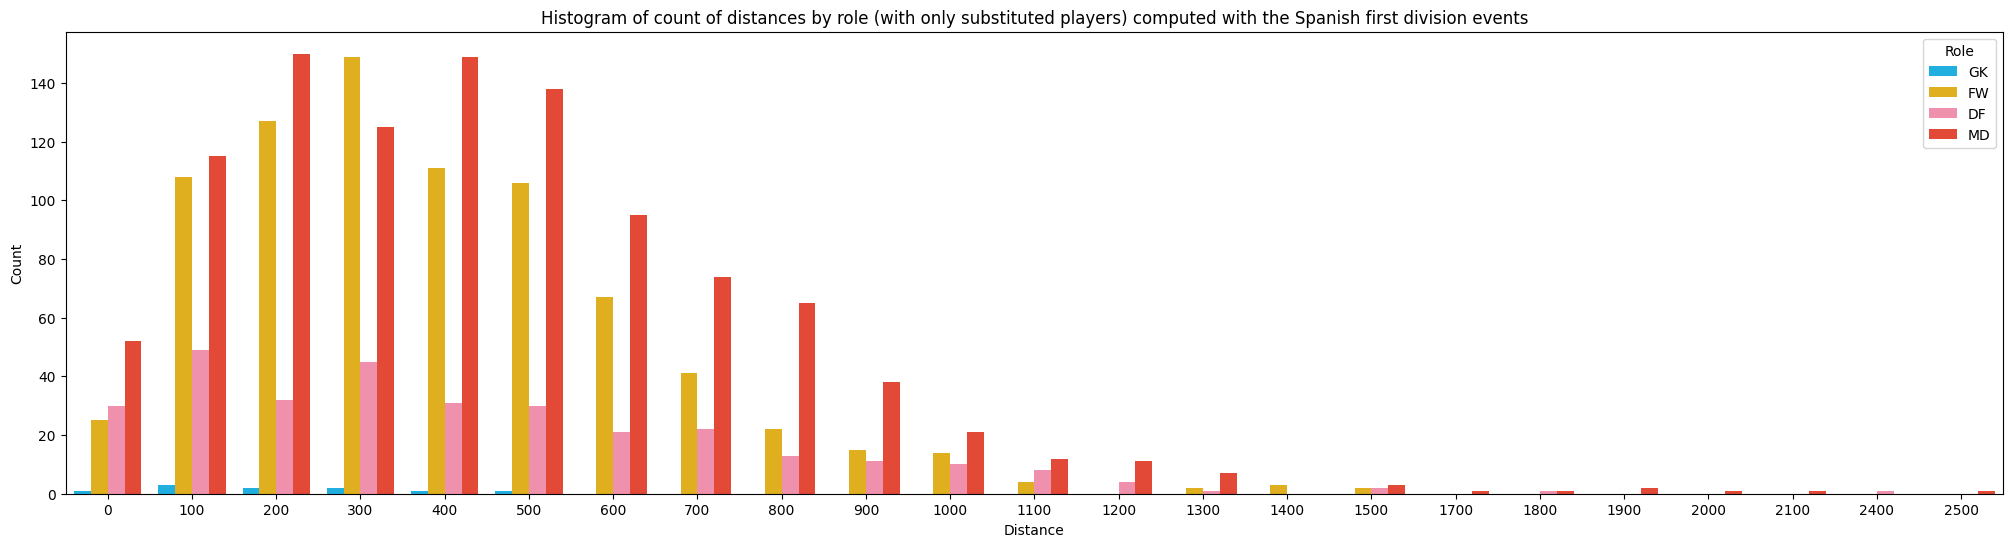

In [23]:
df1 = substitution_analysis(filtered_df, 'Spain', 'Spanish first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## German first division analysis

General analysis for German first division


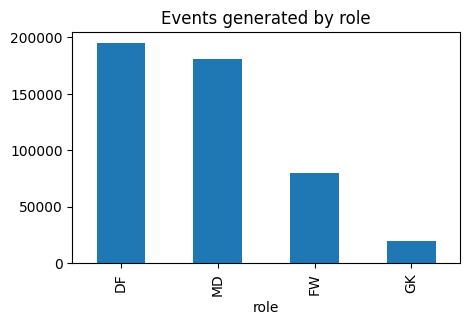

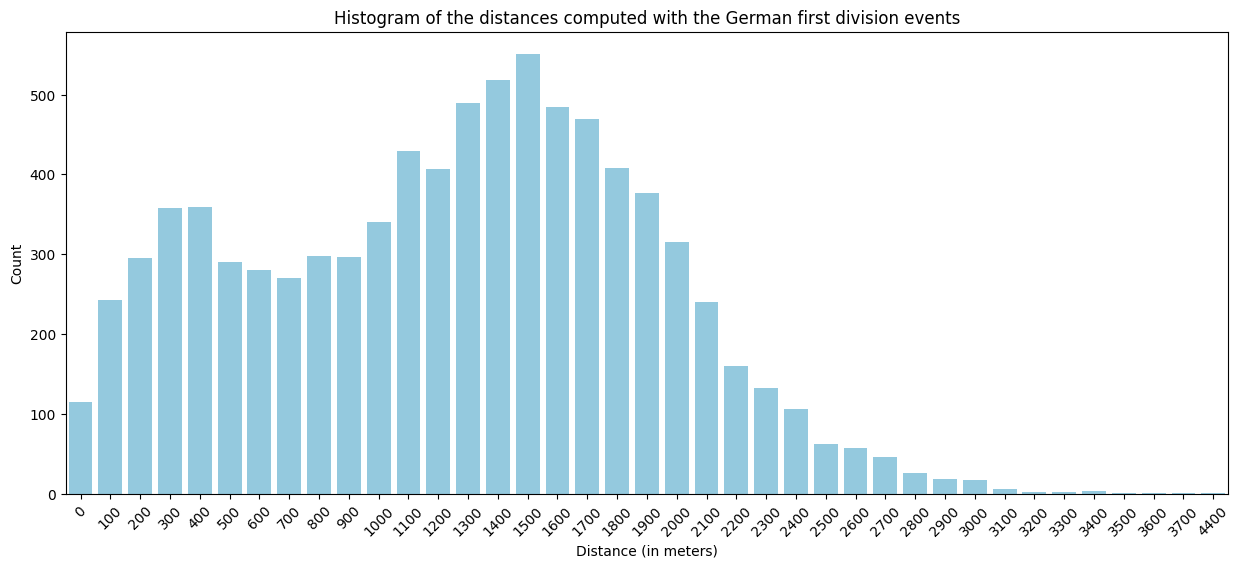

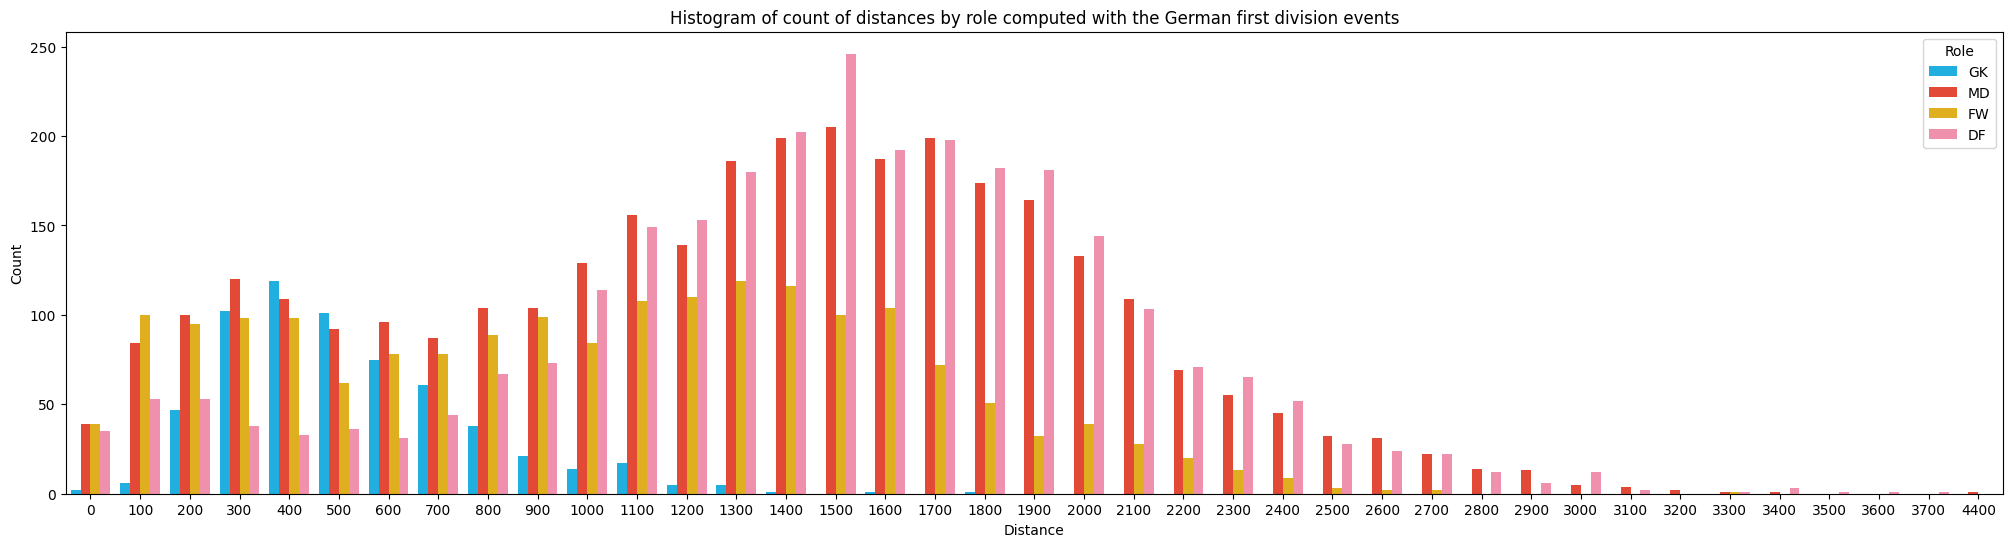

In [24]:
german_events_df, df1, df2 = general_analysis('Germany', 'German first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for German first division


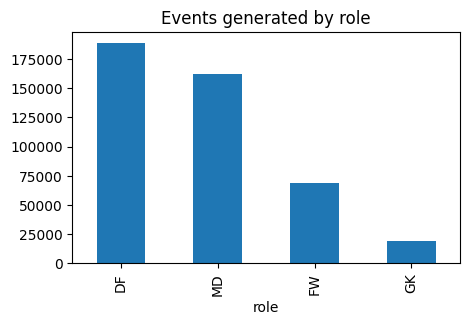

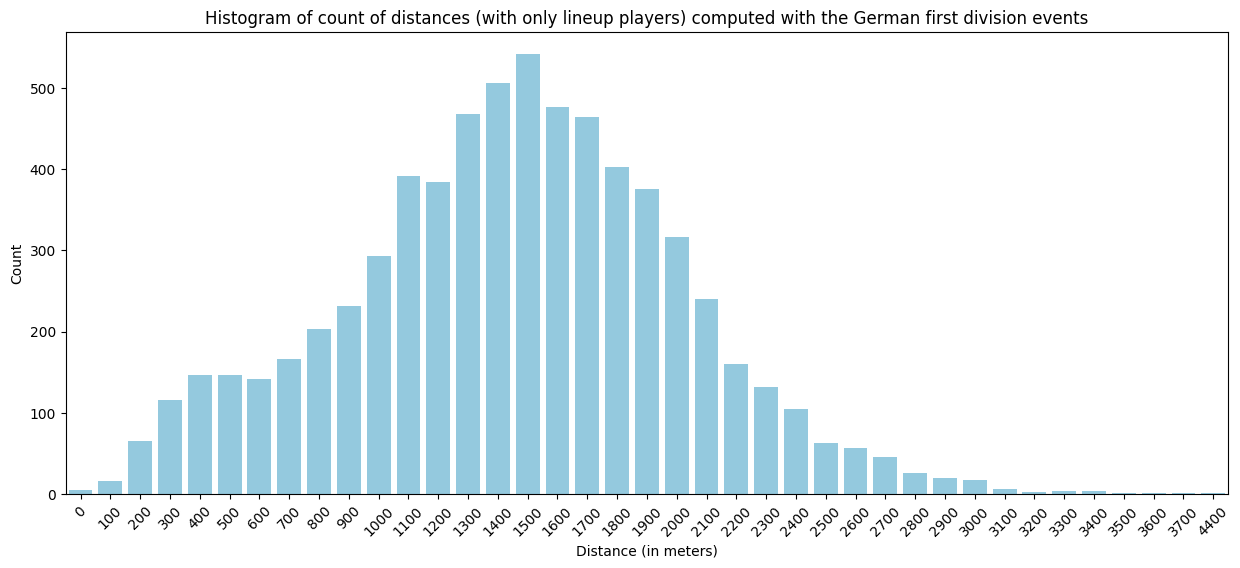

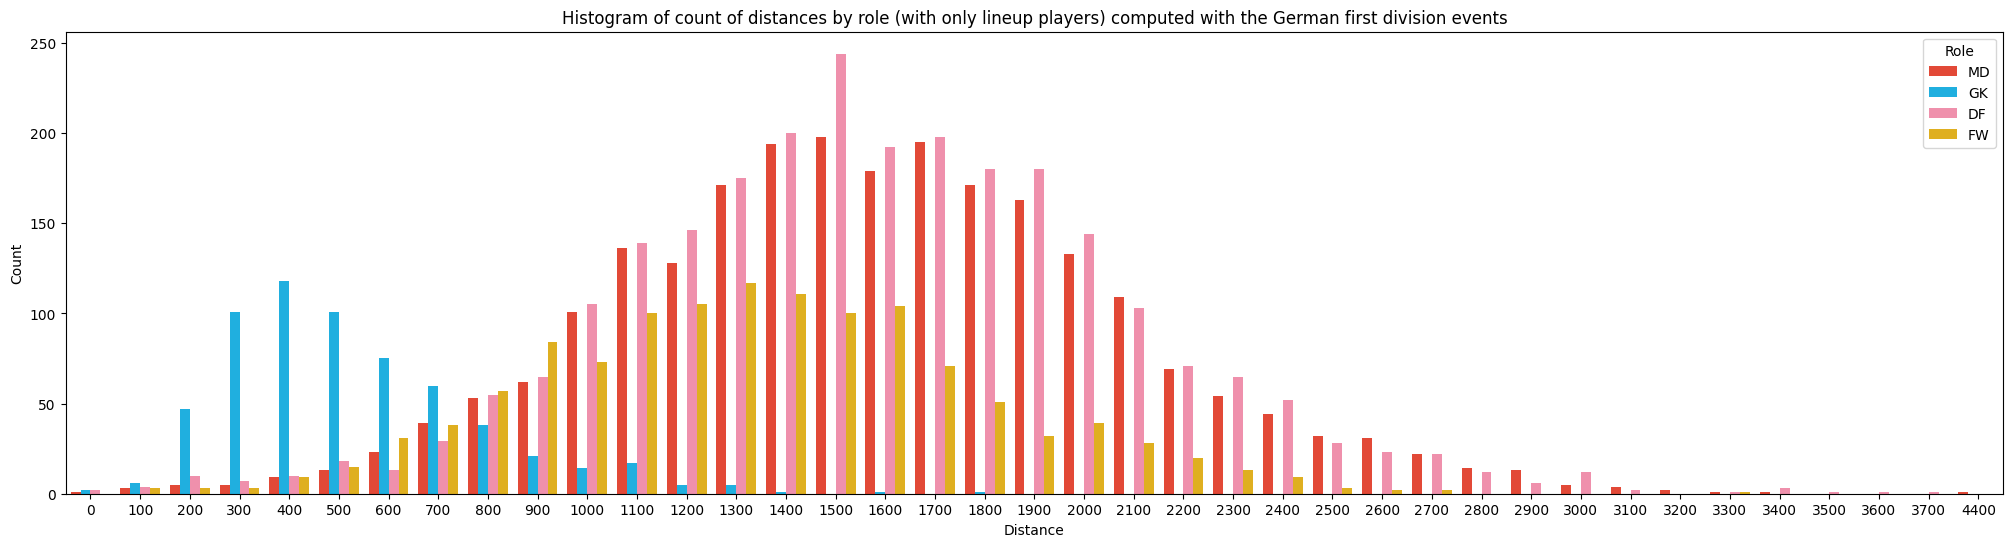

In [25]:
filtered_df, df1 = lineup_analysis(german_events_df, 'Germany', 'German first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

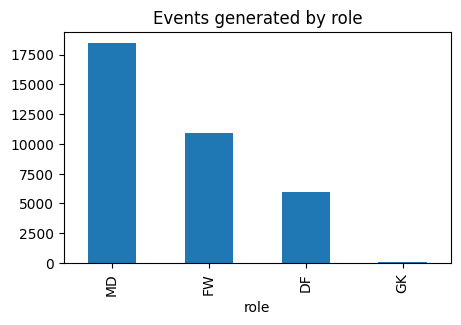

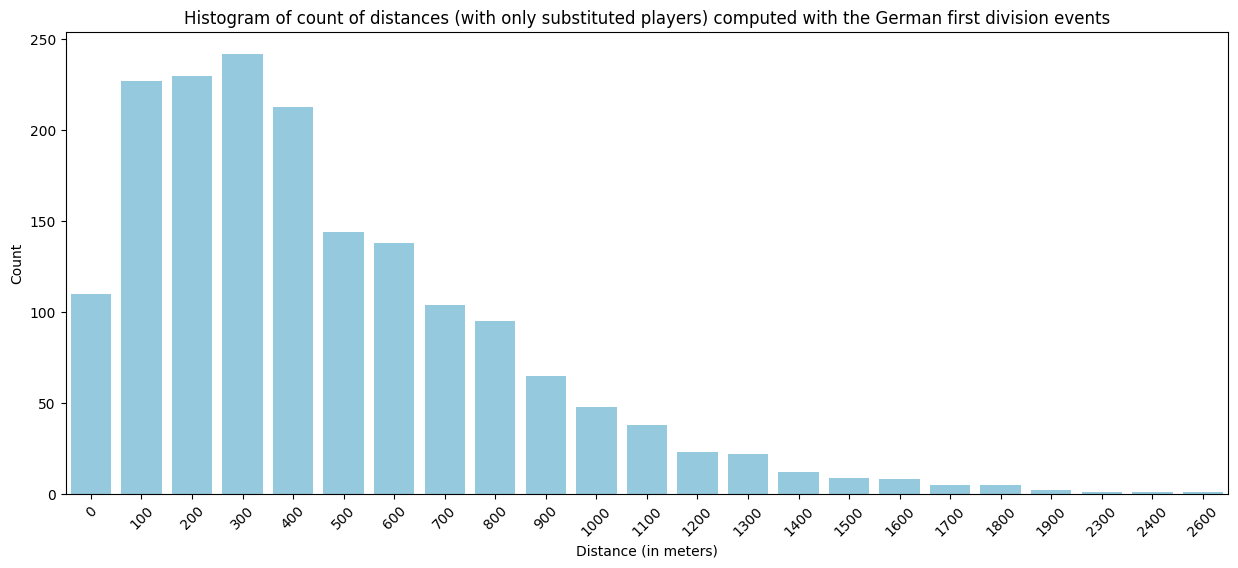

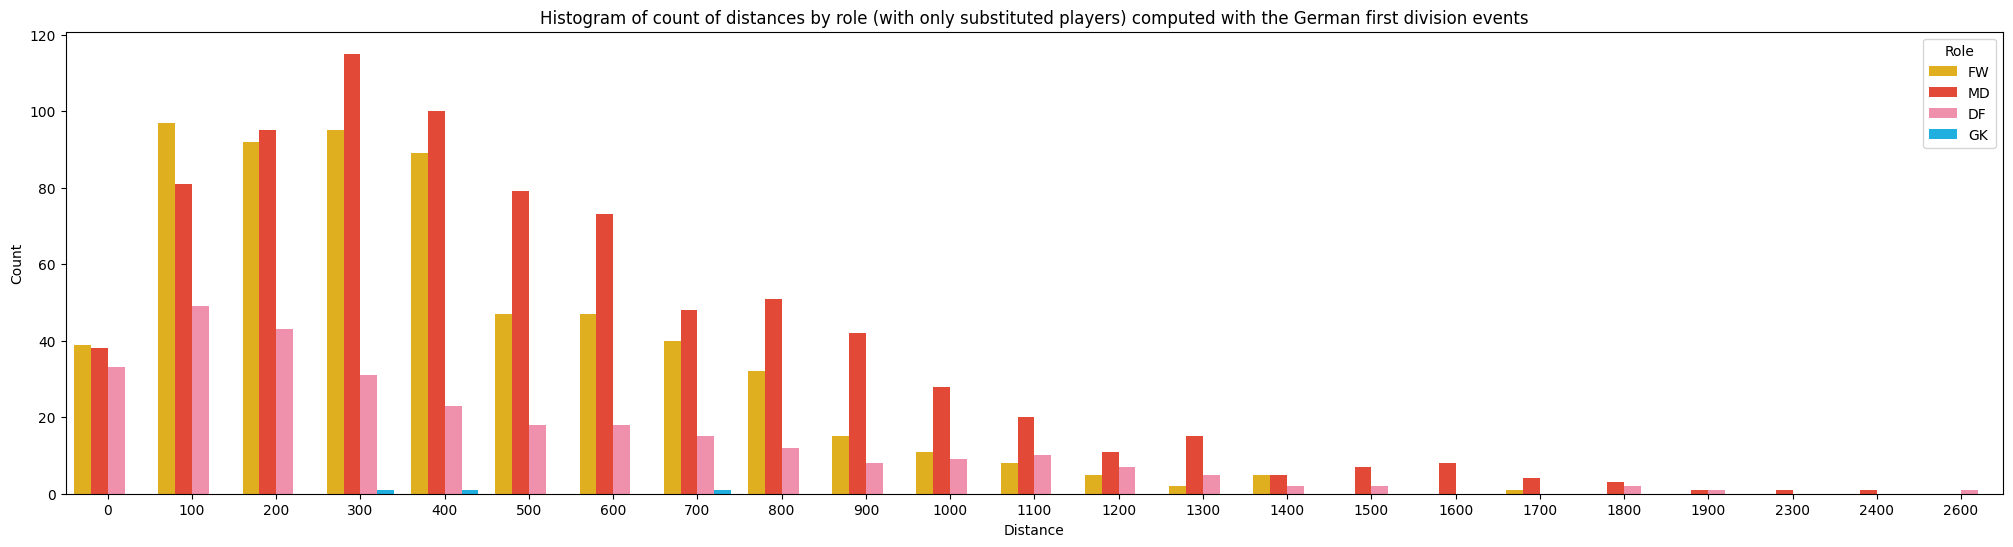

In [26]:
df1 = substitution_analysis(filtered_df, 'Germany', 'German first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## French first division analysis

General analysis for French first division


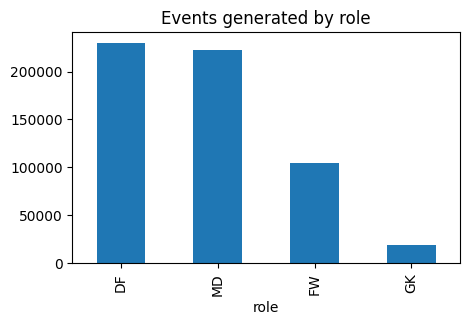

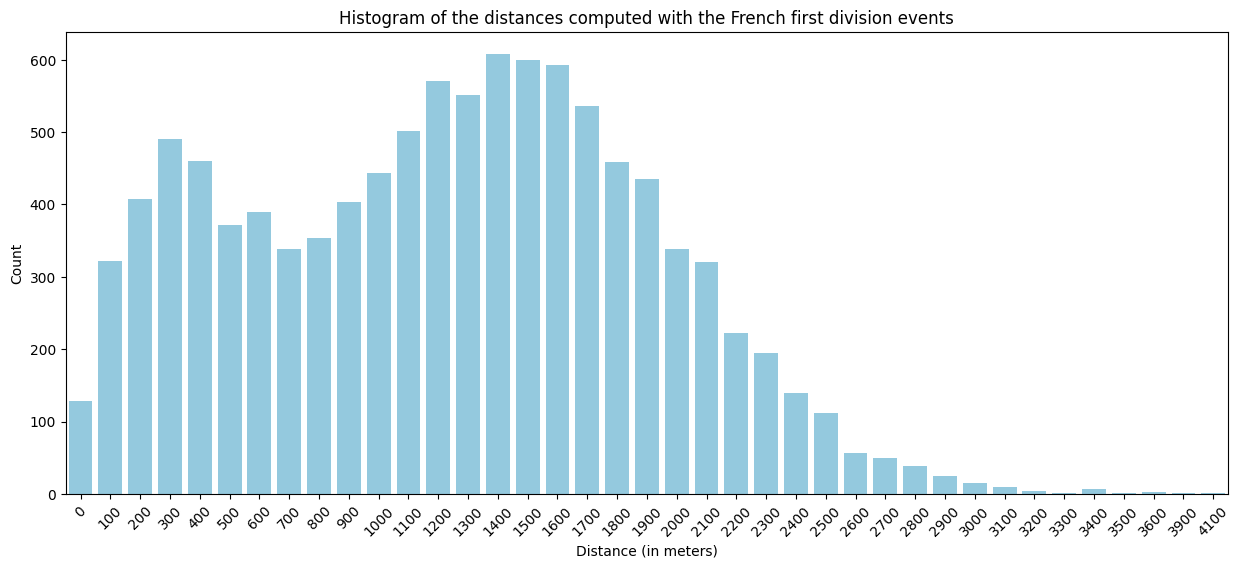

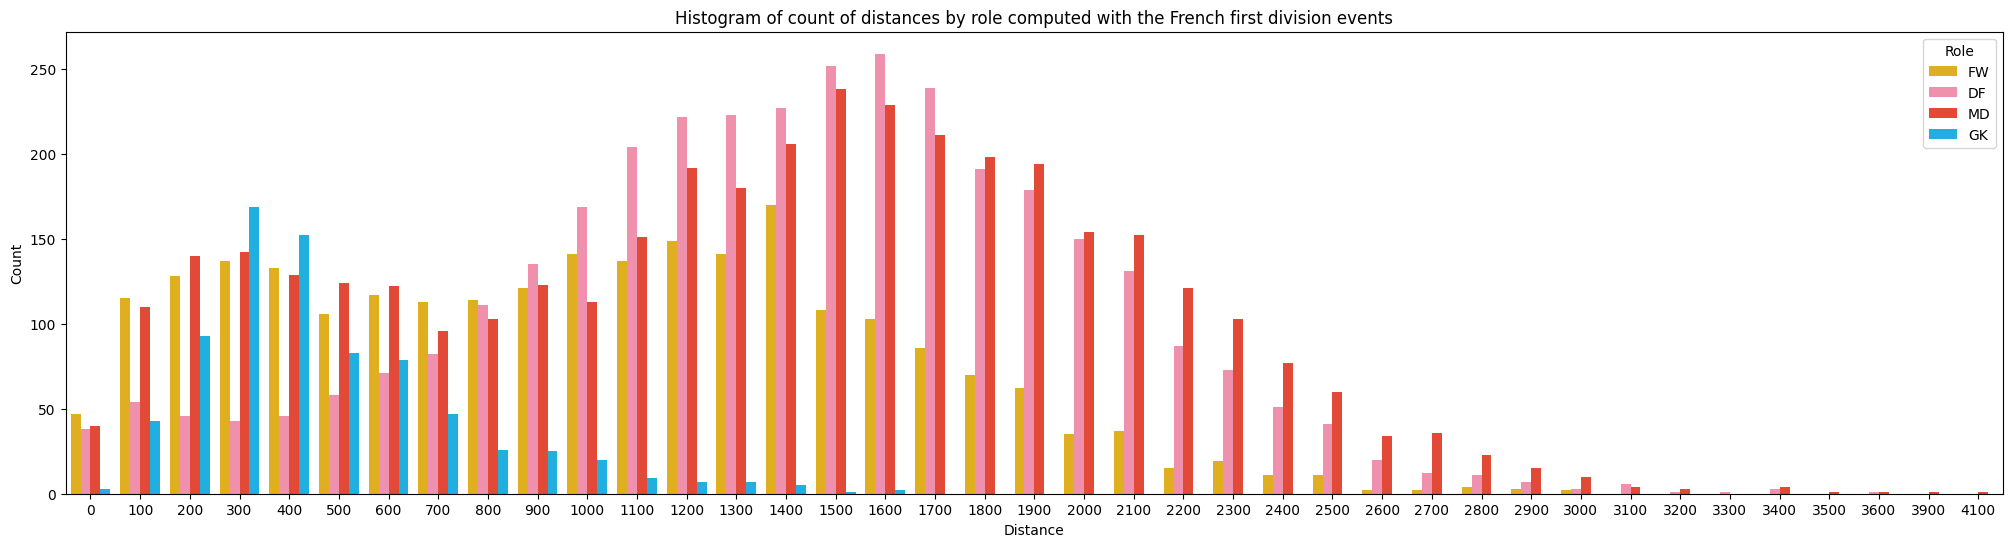

In [27]:
french_events_df, df1, df2 = general_analysis('France', 'French first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for French first division


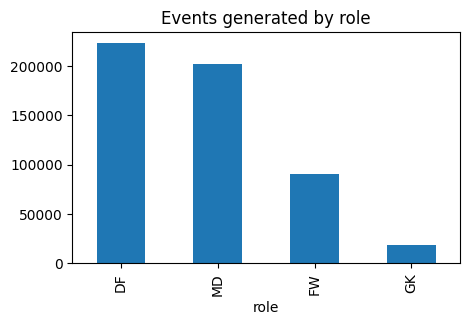

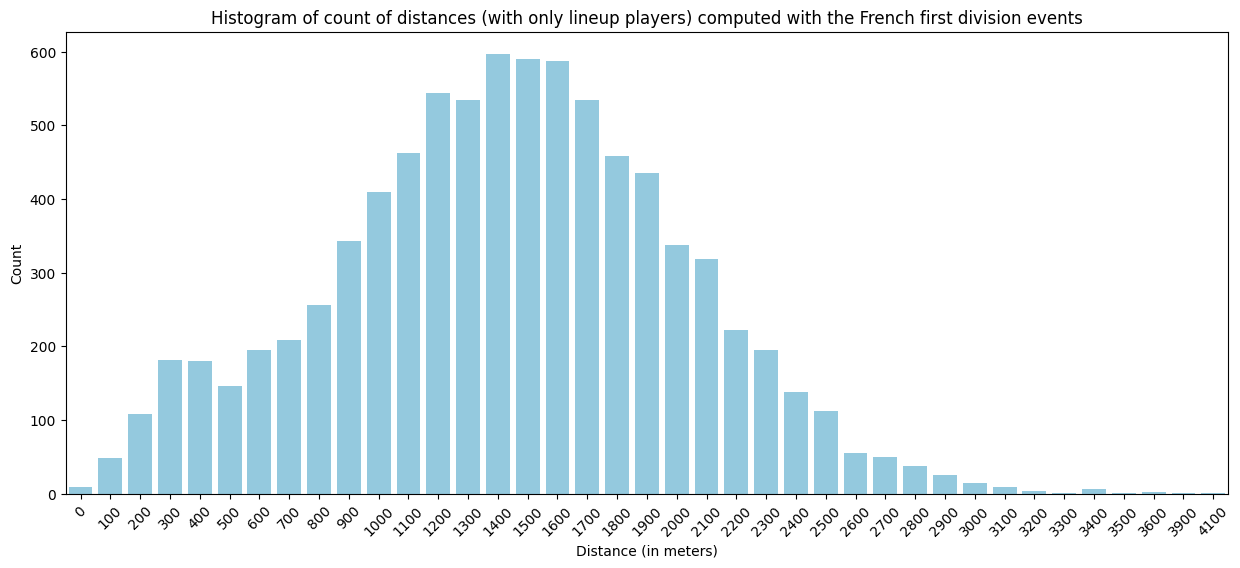

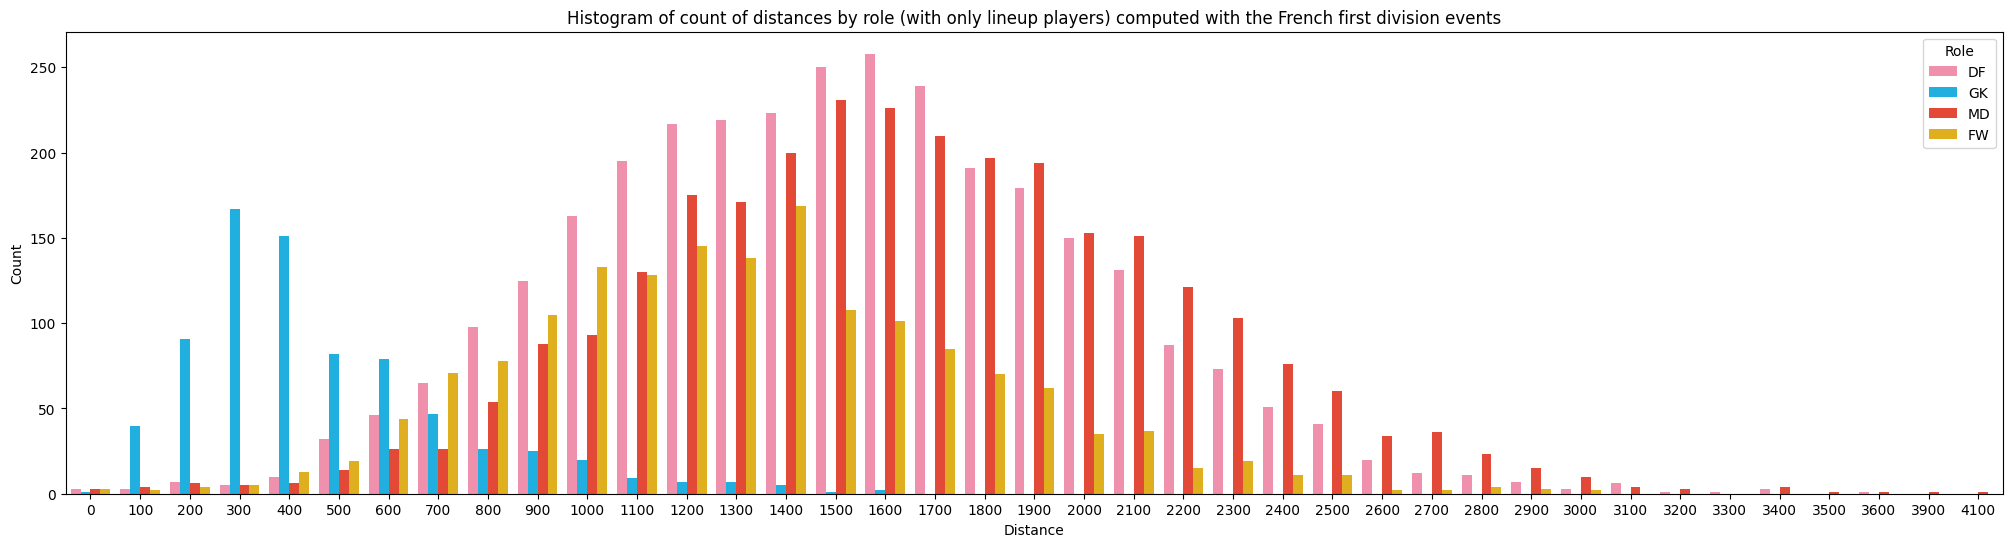

In [28]:
filtered_df, df1 = lineup_analysis(french_events_df, 'France', 'French first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

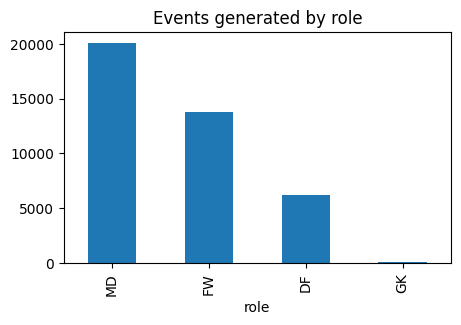

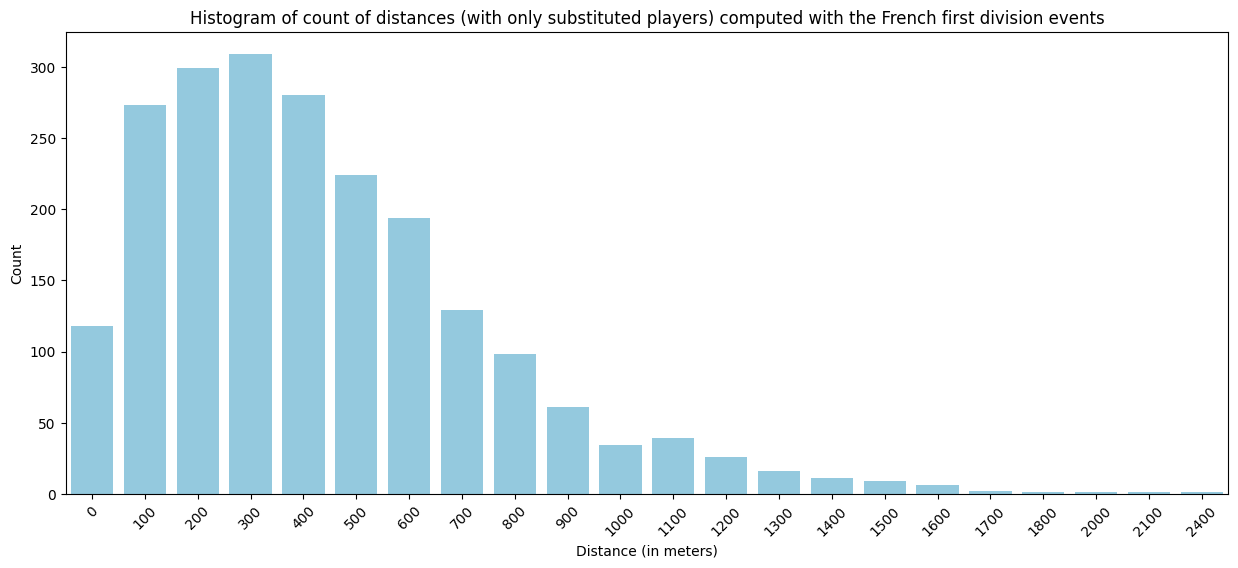

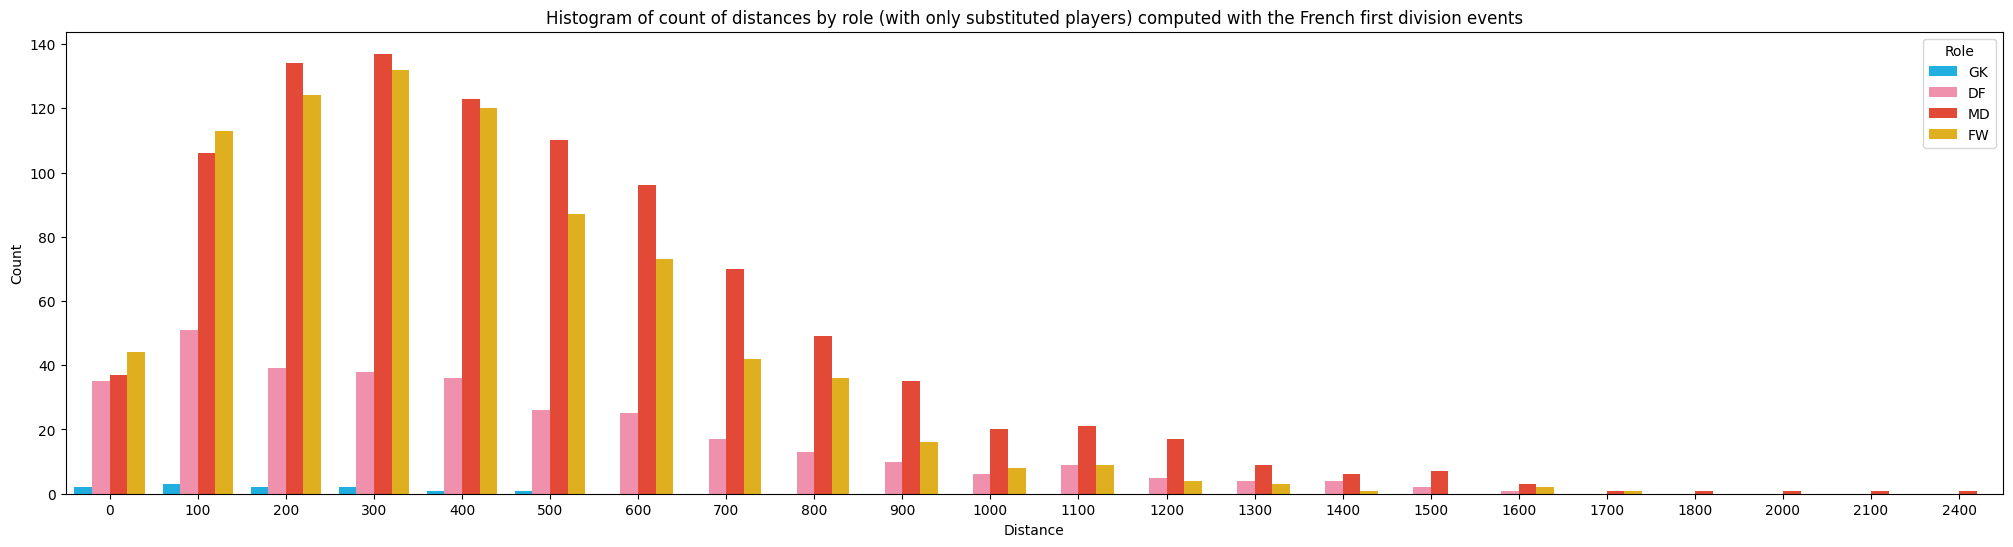

In [29]:
df1 = substitution_analysis(filtered_df, 'France', 'French first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## European Championship

General analysis for European Championship


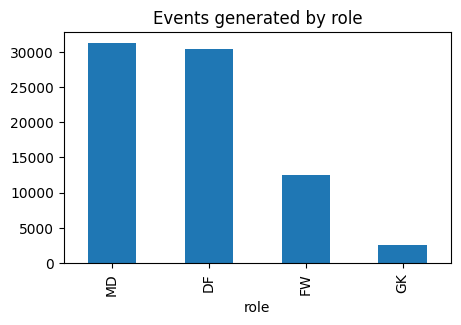

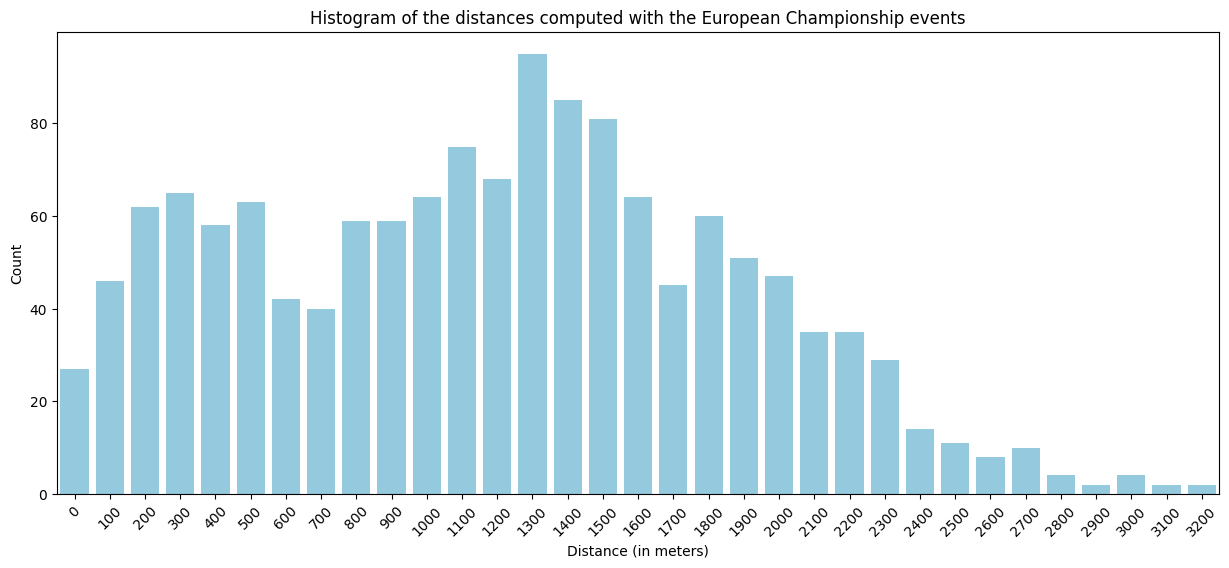

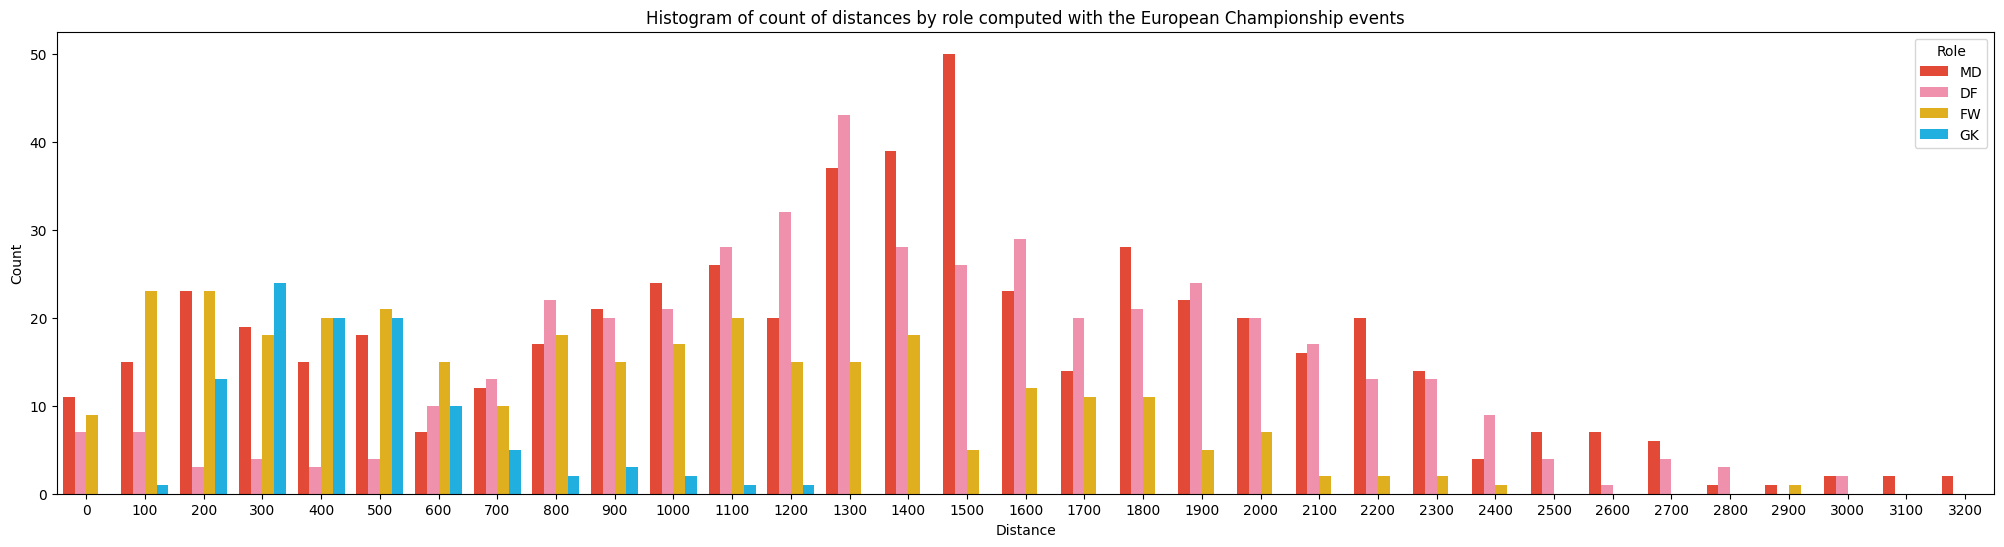

In [30]:
european_events_df, df1, df2 = general_analysis('European_Championship', 'European Championship')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for European Championship


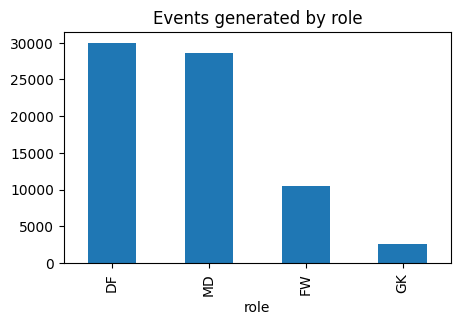

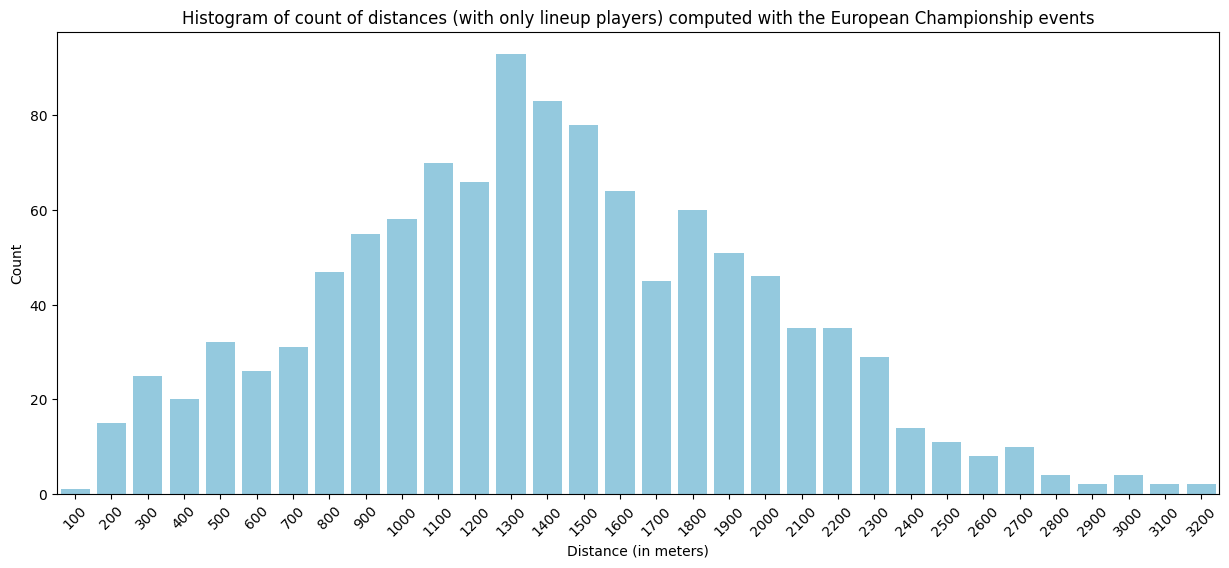

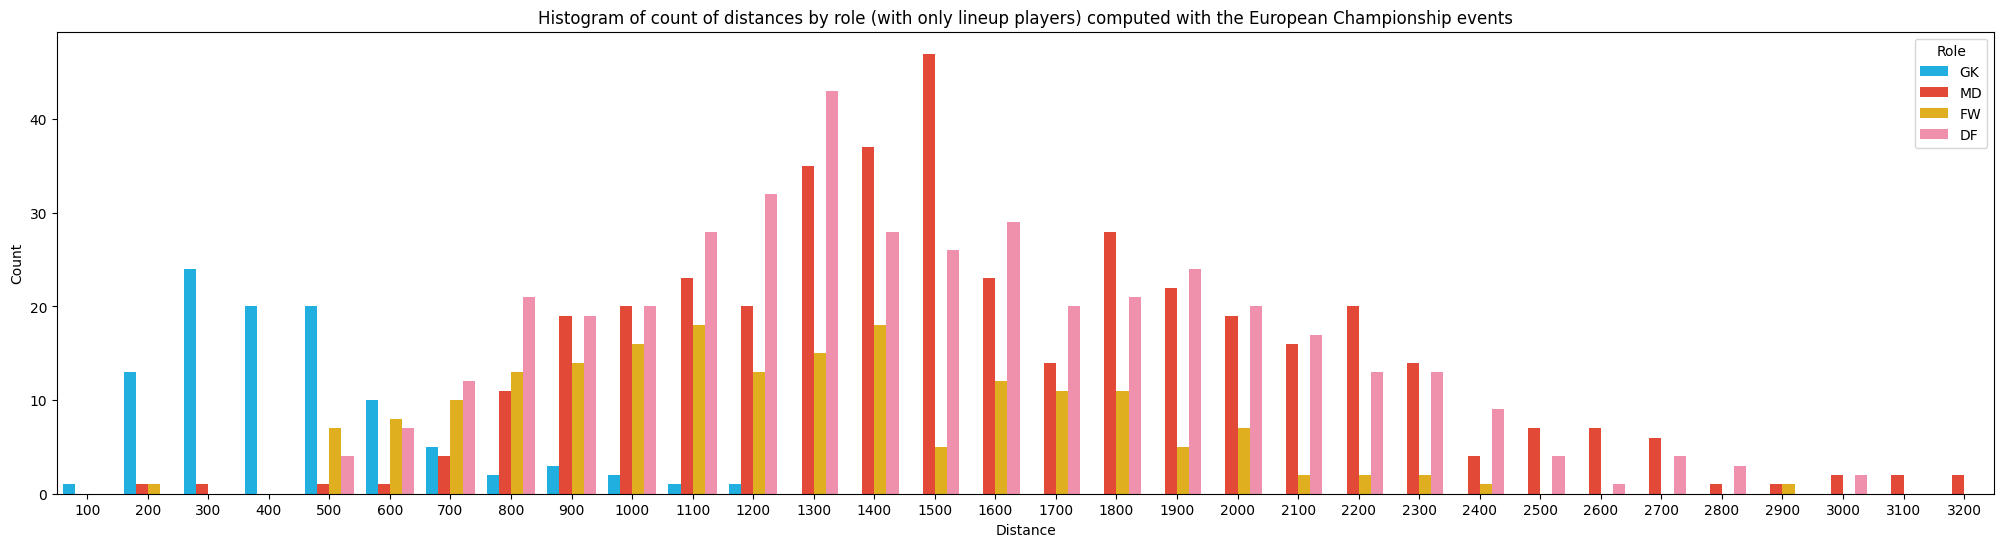

In [31]:
filtered_df, df1 = lineup_analysis(european_events_df, 'European_Championship', 'European Championship')

lineup_players_df = pd.concat([lineup_players_df, df1])

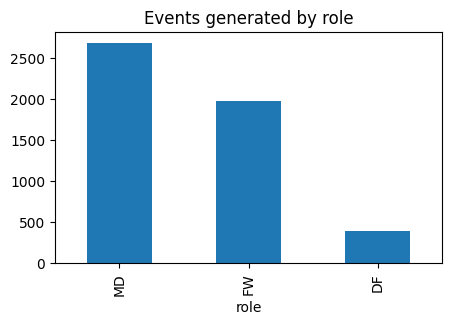

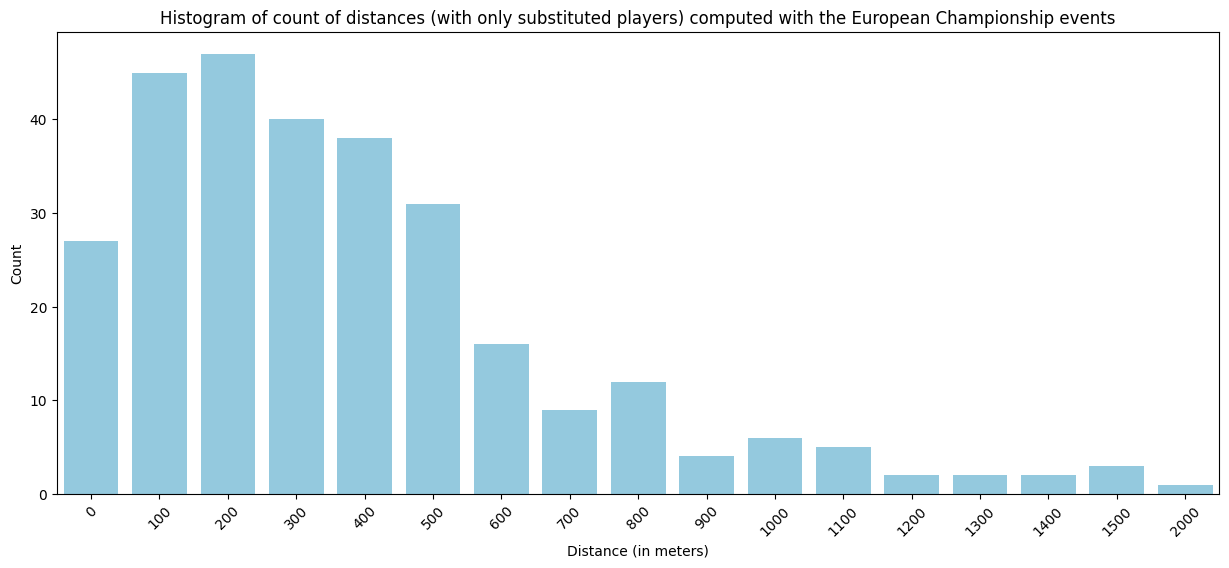

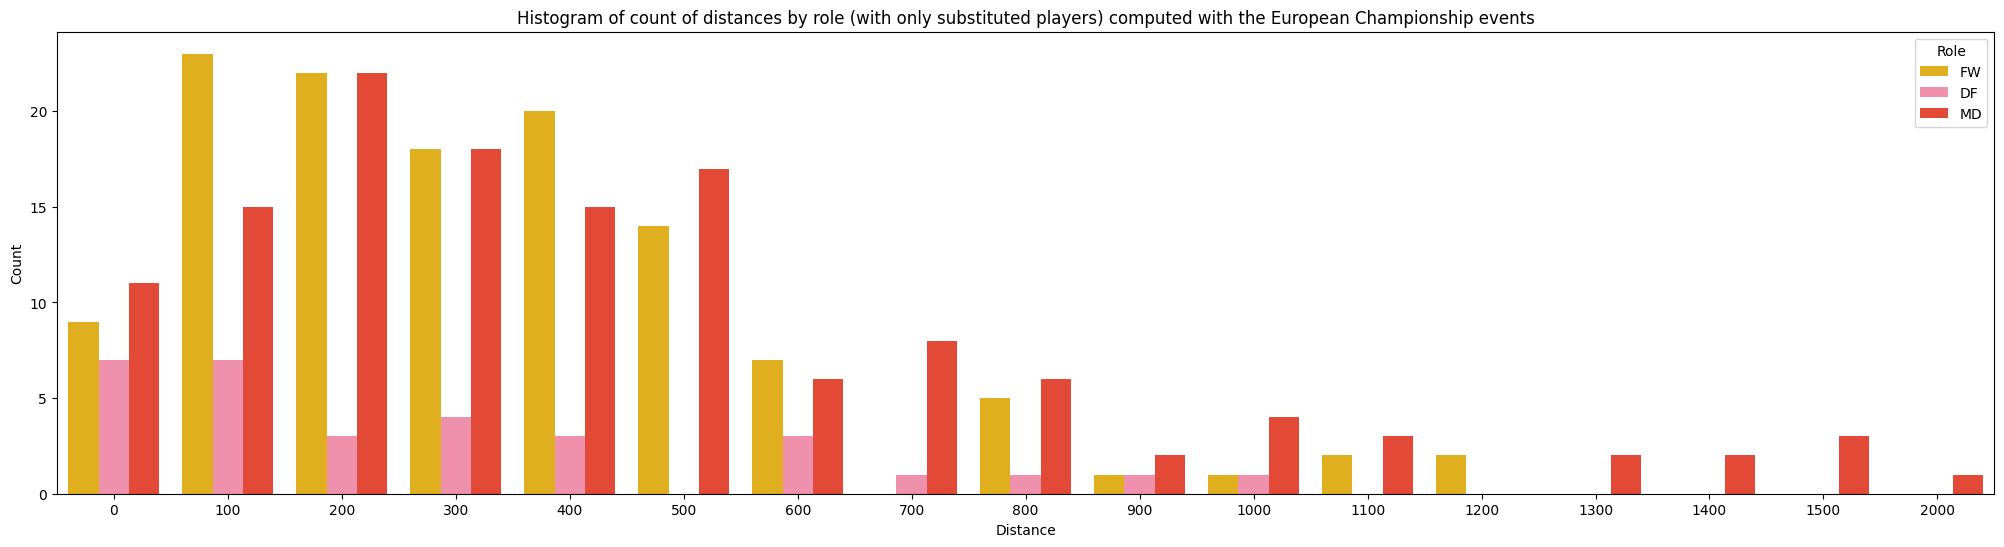

In [32]:
df1 = substitution_analysis(filtered_df, 'European_Championship', 'European Championship')

substitution_players_df = pd.concat([substitution_players_df, df1])

## World Cup

General analysis for World Cup


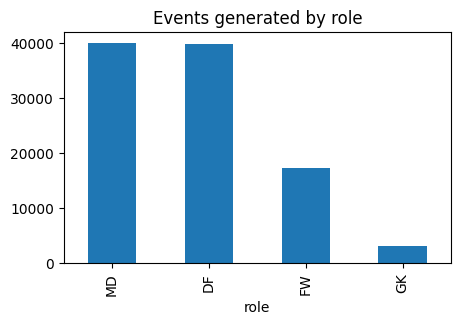

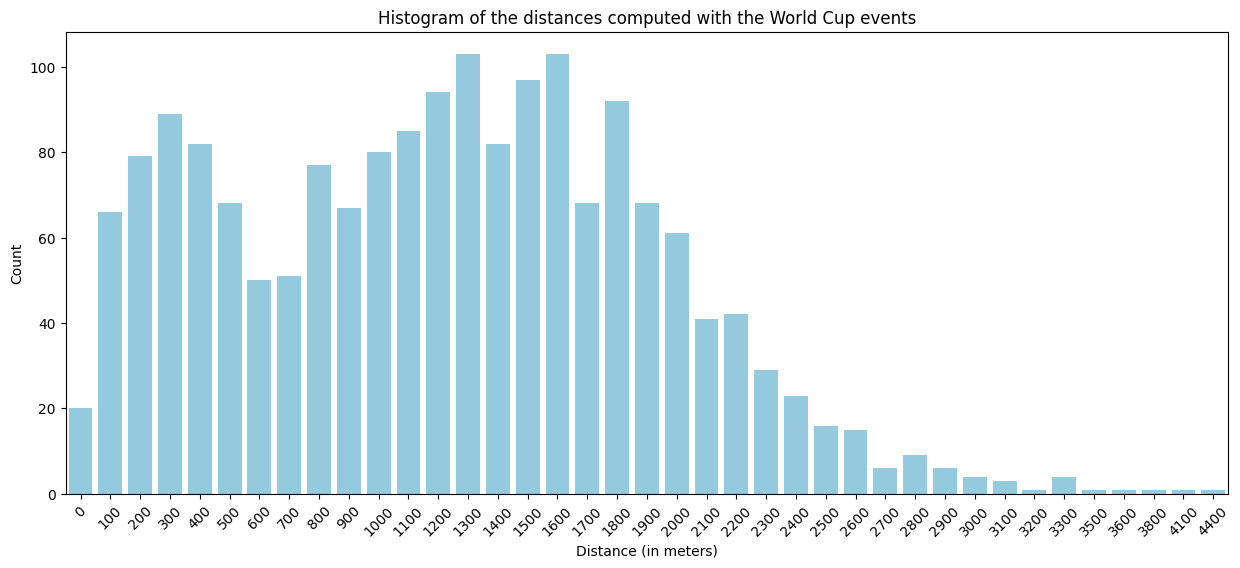

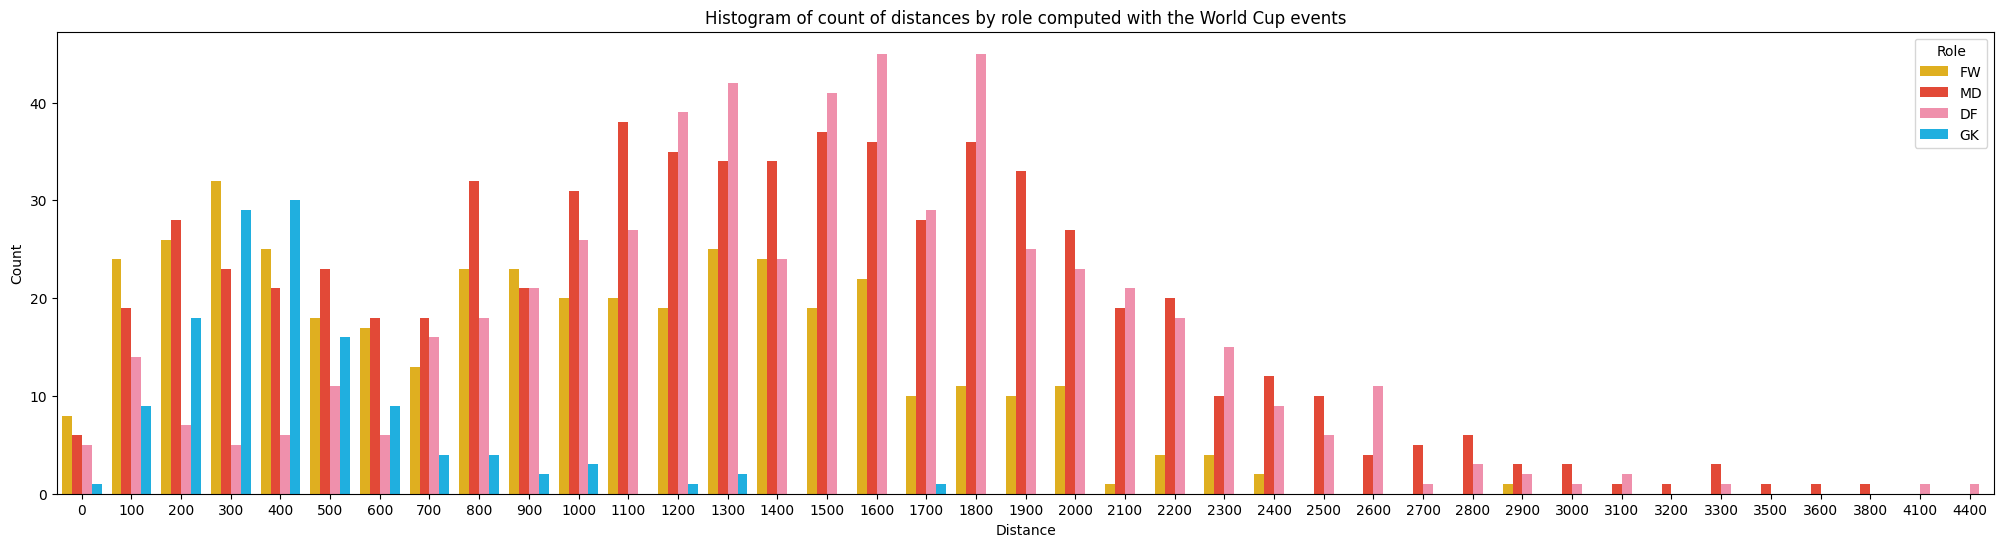

In [33]:
world_events_df, df1, df2 = general_analysis('World_Cup', 'World Cup')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for World_Cup


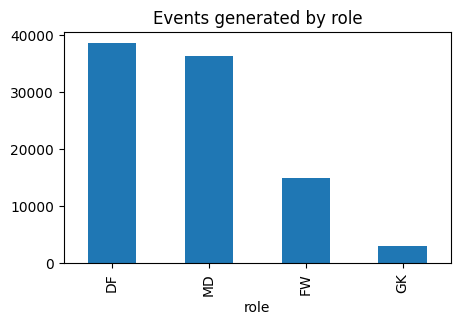

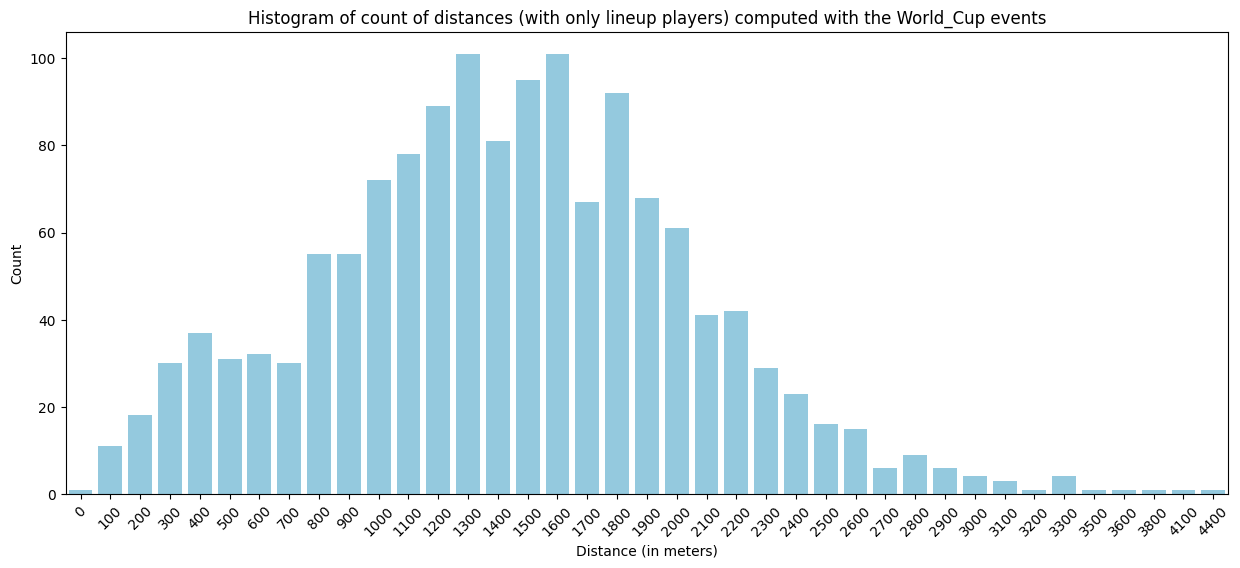

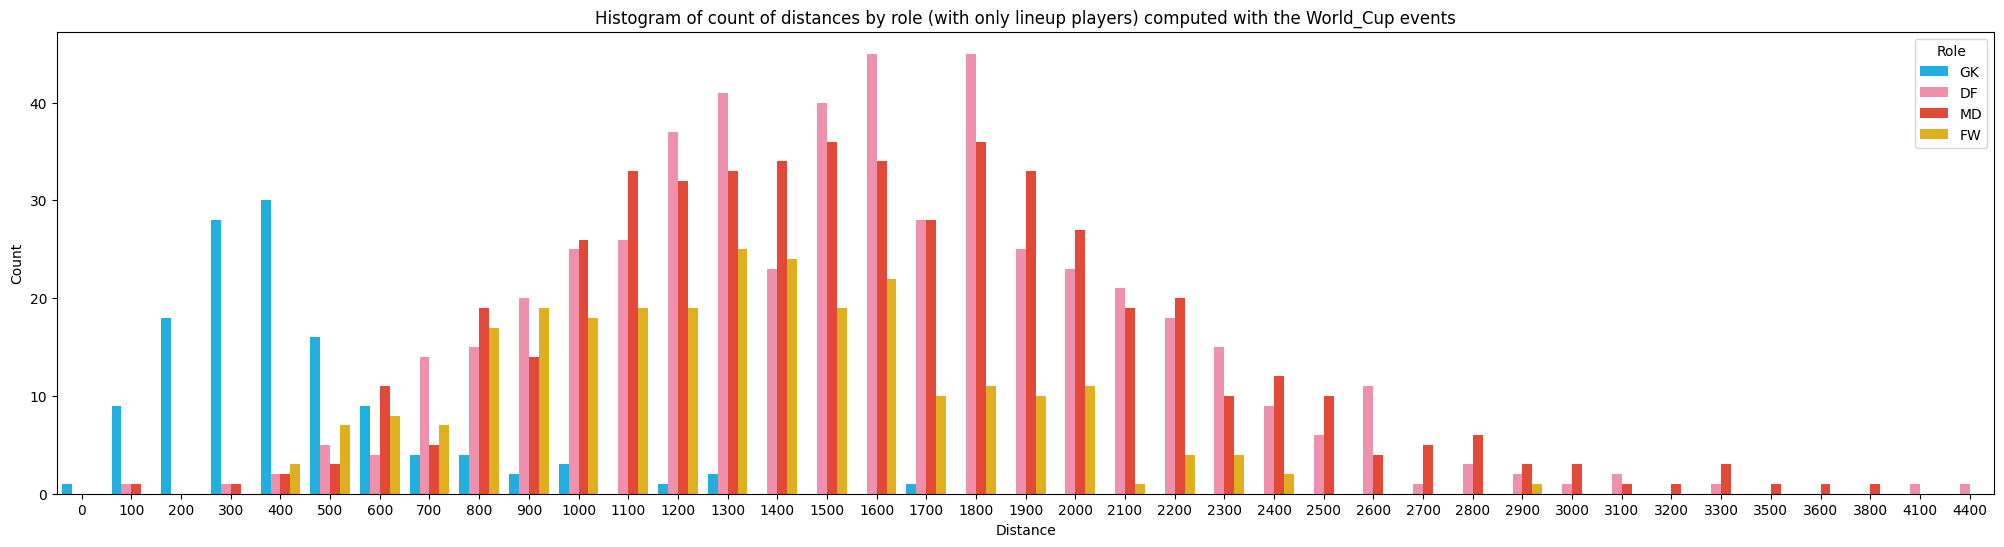

In [34]:
filtered_df, df1 = lineup_analysis(world_events_df, 'World_Cup', 'World_Cup')

lineup_players_df = pd.concat([lineup_players_df, df1])

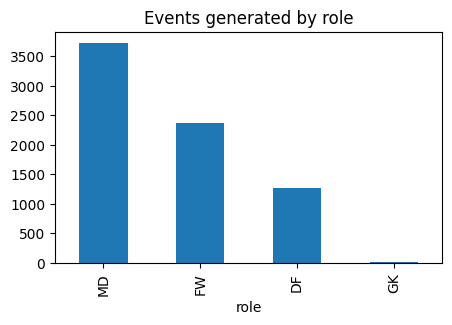

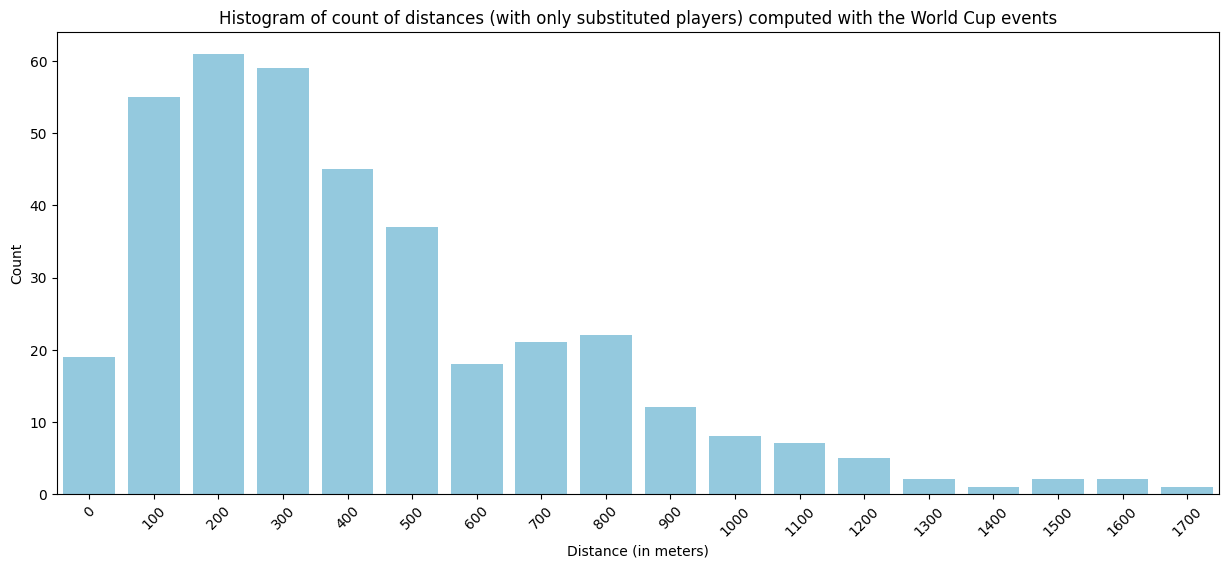

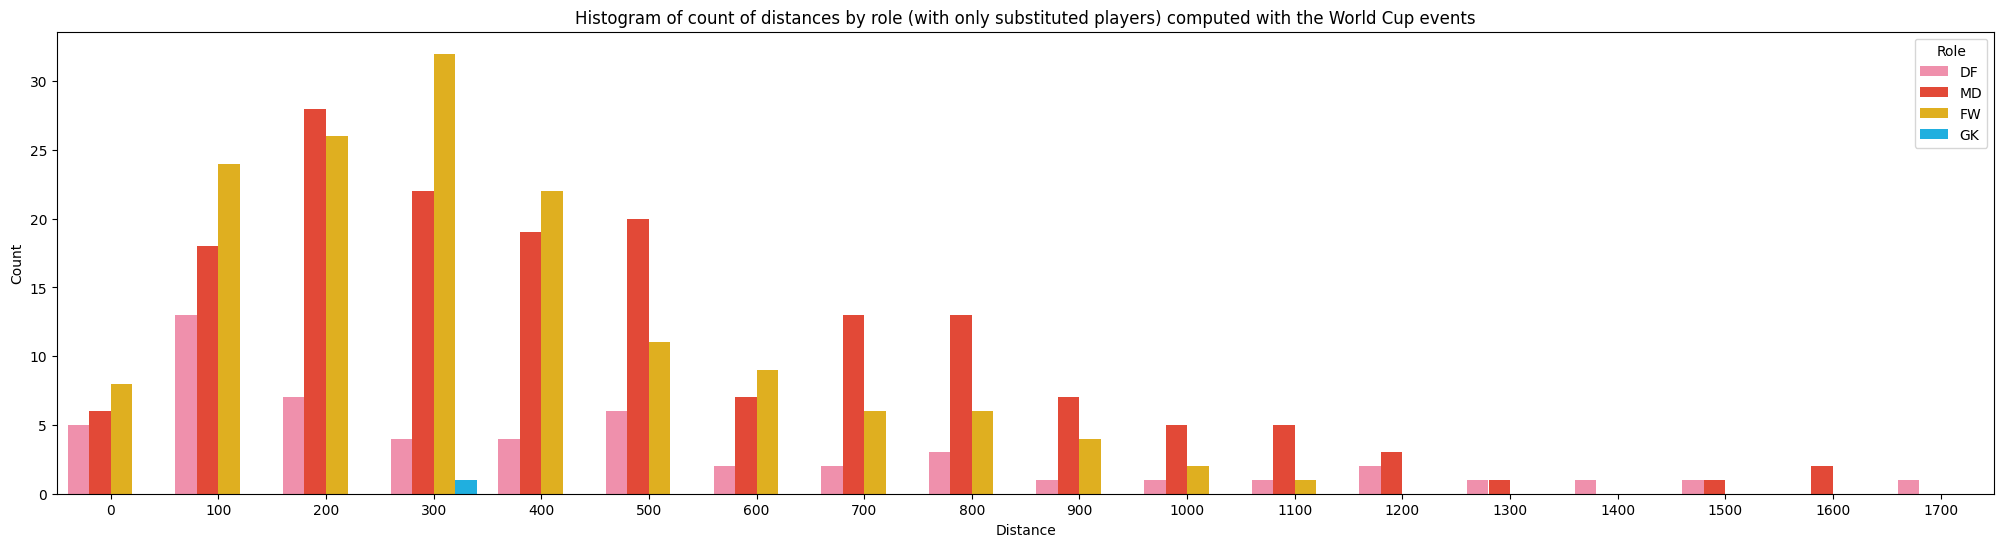

In [35]:
df1 = substitution_analysis(filtered_df, 'World_Cup', 'World Cup')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Total distances

General analysis


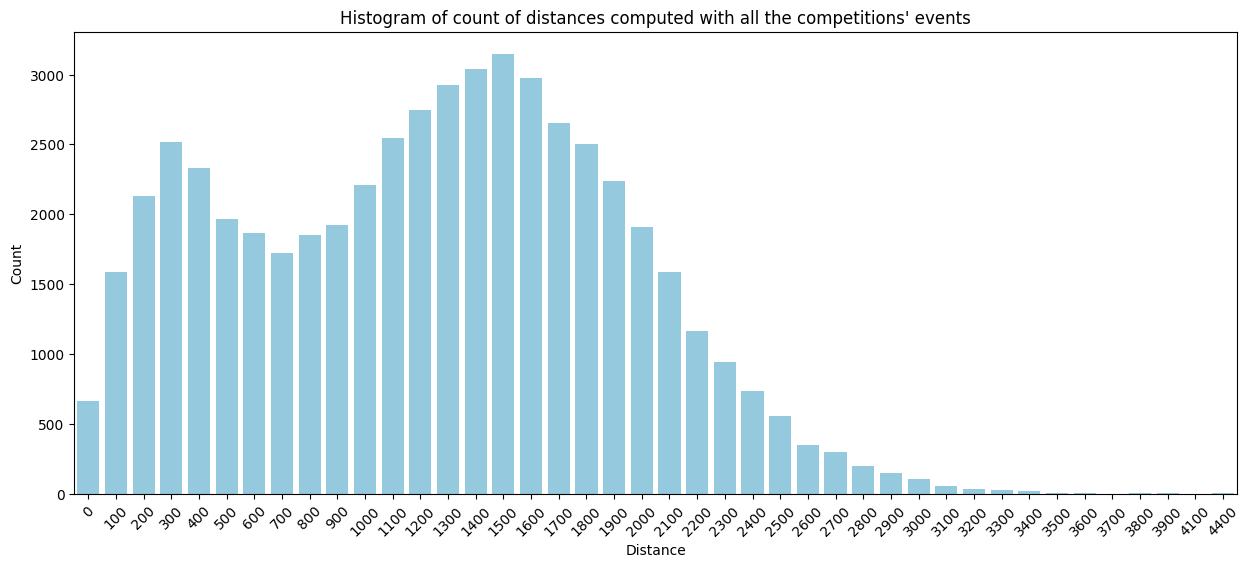

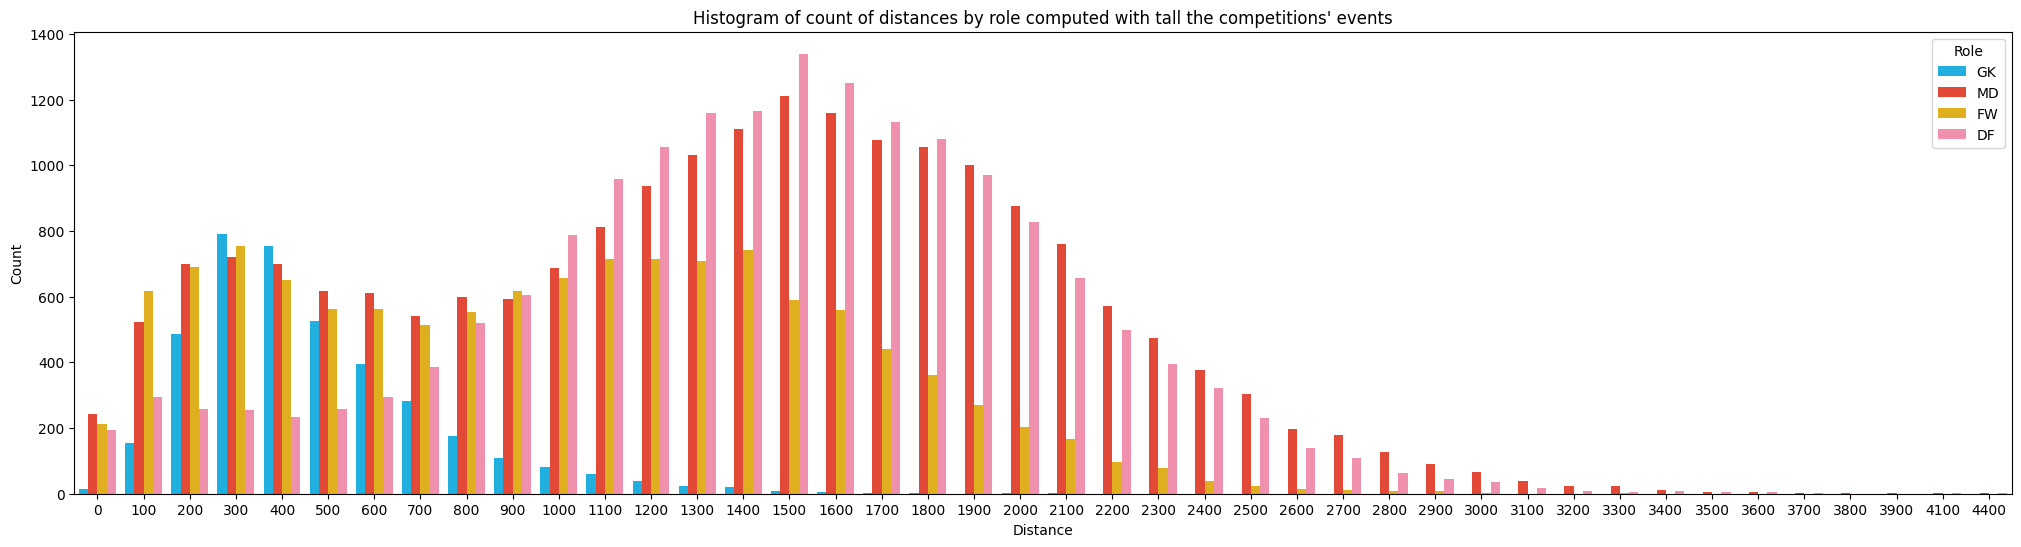

In [36]:
total_analysis()

Lineup analysis


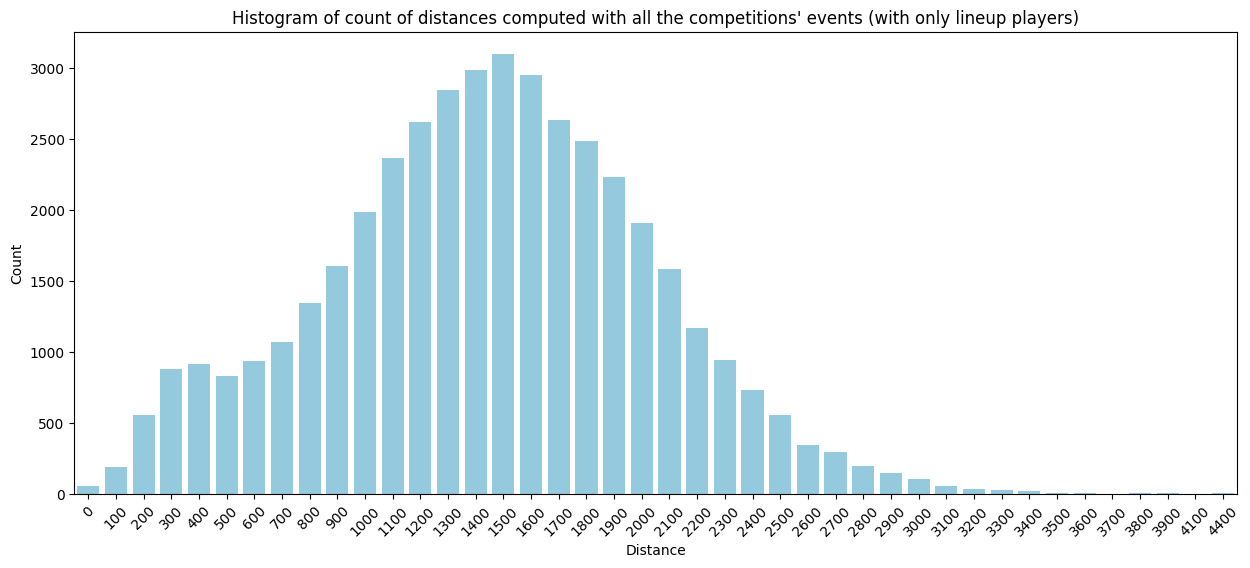

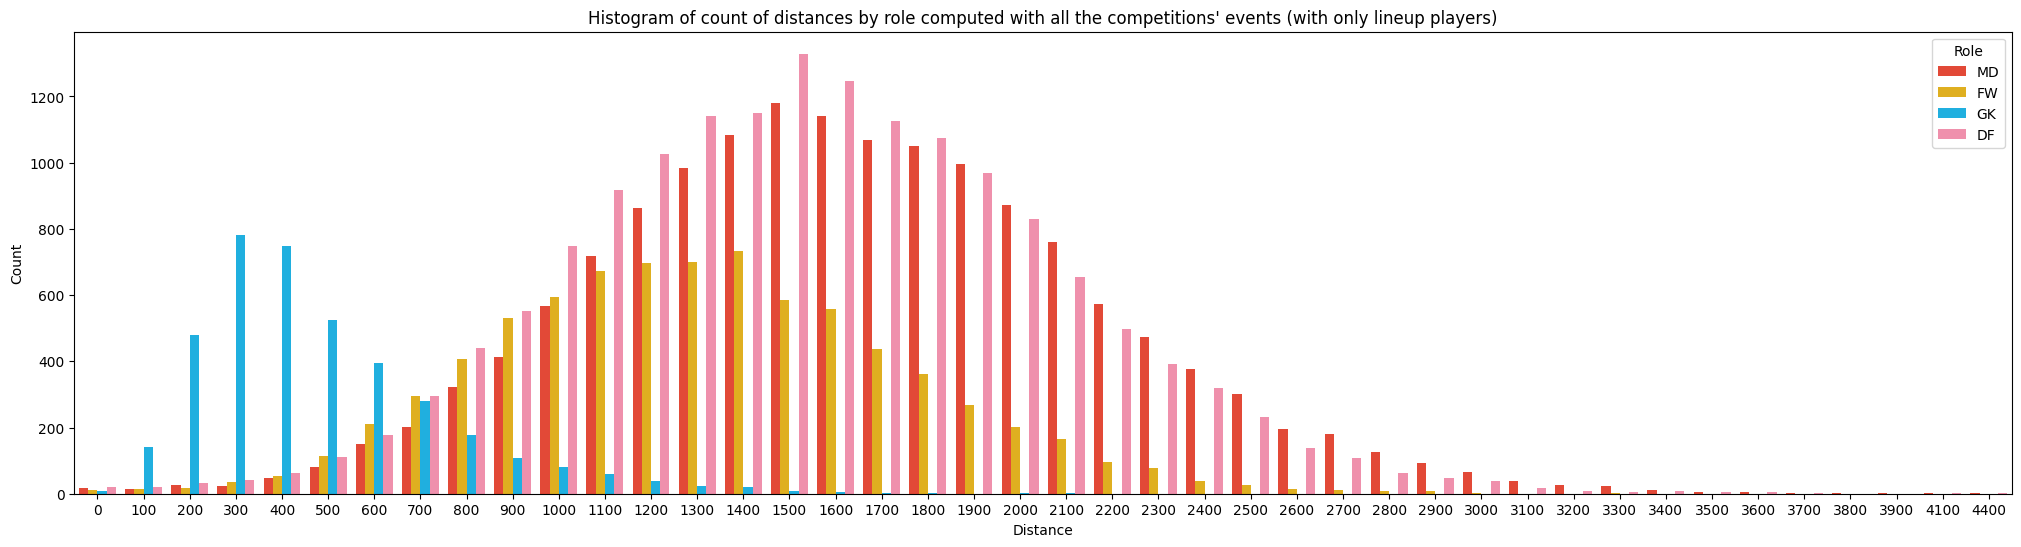

In [37]:
lineup_total_analysis()

Substitution analysis


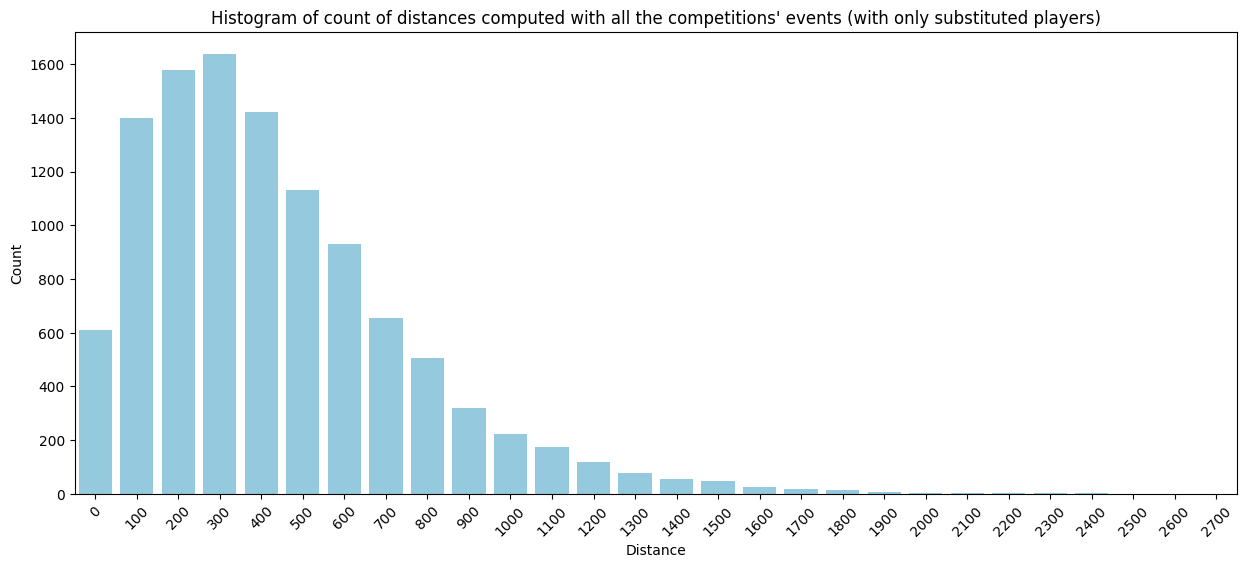

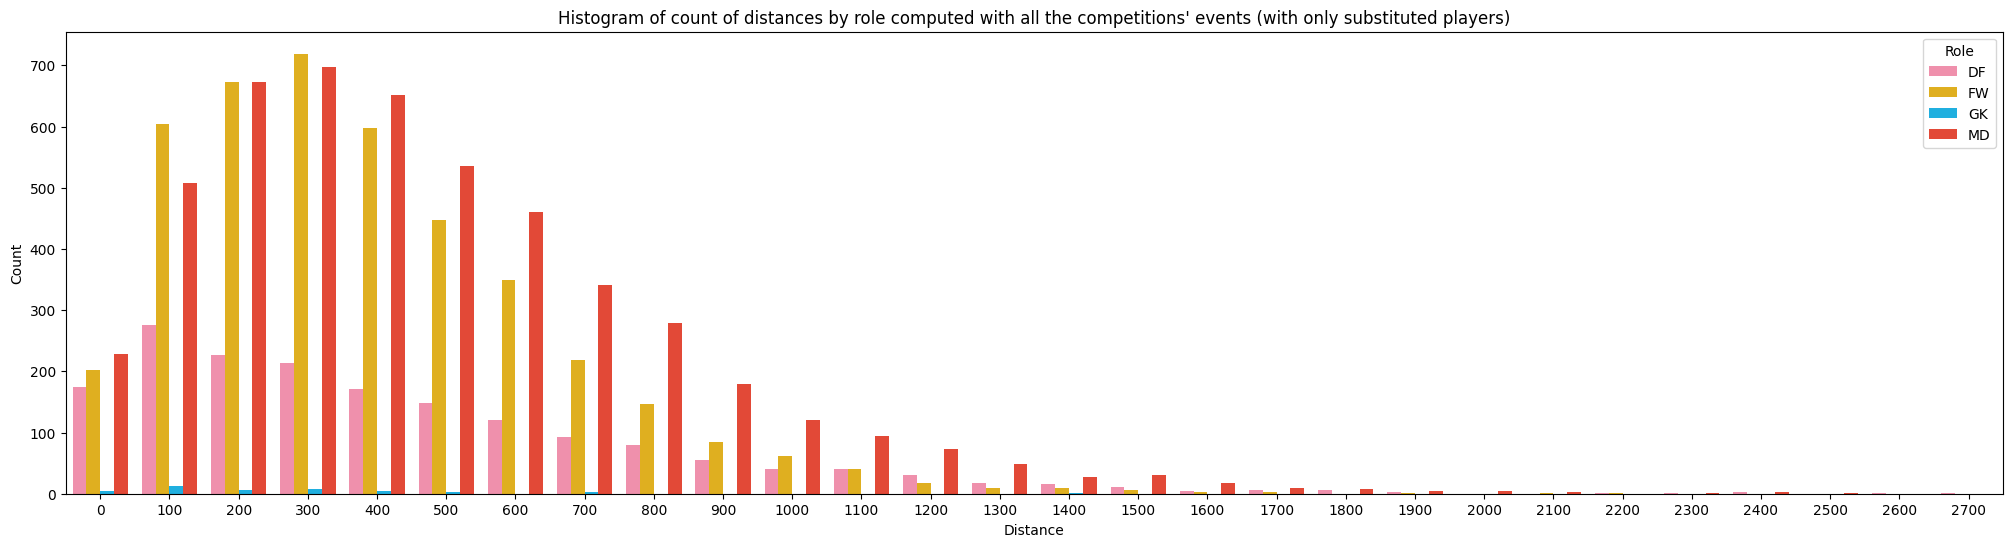

In [38]:
substitution_total_analysis()